<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 302</h1>
<h1>Age structure</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import string

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from ipywidgets import interact

import epidemik
from epidemik import EpiModel

import os

import tqdm as tq
from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by printing out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: d8a9dc21c16d07955c290a5daf045900a0bfc4fd

numpy     : 1.26.4
tqdm      : 4.66.2
pandas    : 2.1.4
matplotlib: 3.8.0
epidemik  : 0.0.11
watermark : 2.4.3
seaborn   : 0.12.2



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Age Structure

We start by loading the number of individuals in each age group for two specific contries: UK and Kenya

In [4]:
Nk_uk = pd.read_csv("data/United Kingdom-2020.csv", index_col=0)
Nk_ke = pd.read_csv("data/Kenya-2020.csv", index_col=0)

Ages = Nk_uk.index
Ages.name = None

ages = Nk_uk.join(Nk_ke, lsuffix='_')
ages.columns = ['UK', 'Kenya']
ages['compartment'] = list(string.ascii_lowercase[:ages.shape[0]])

and plot it. Clearly, these two countries have very different population profiles, with Kenya's population being significantly younger

Text(0, 0.5, 'Population (M)')

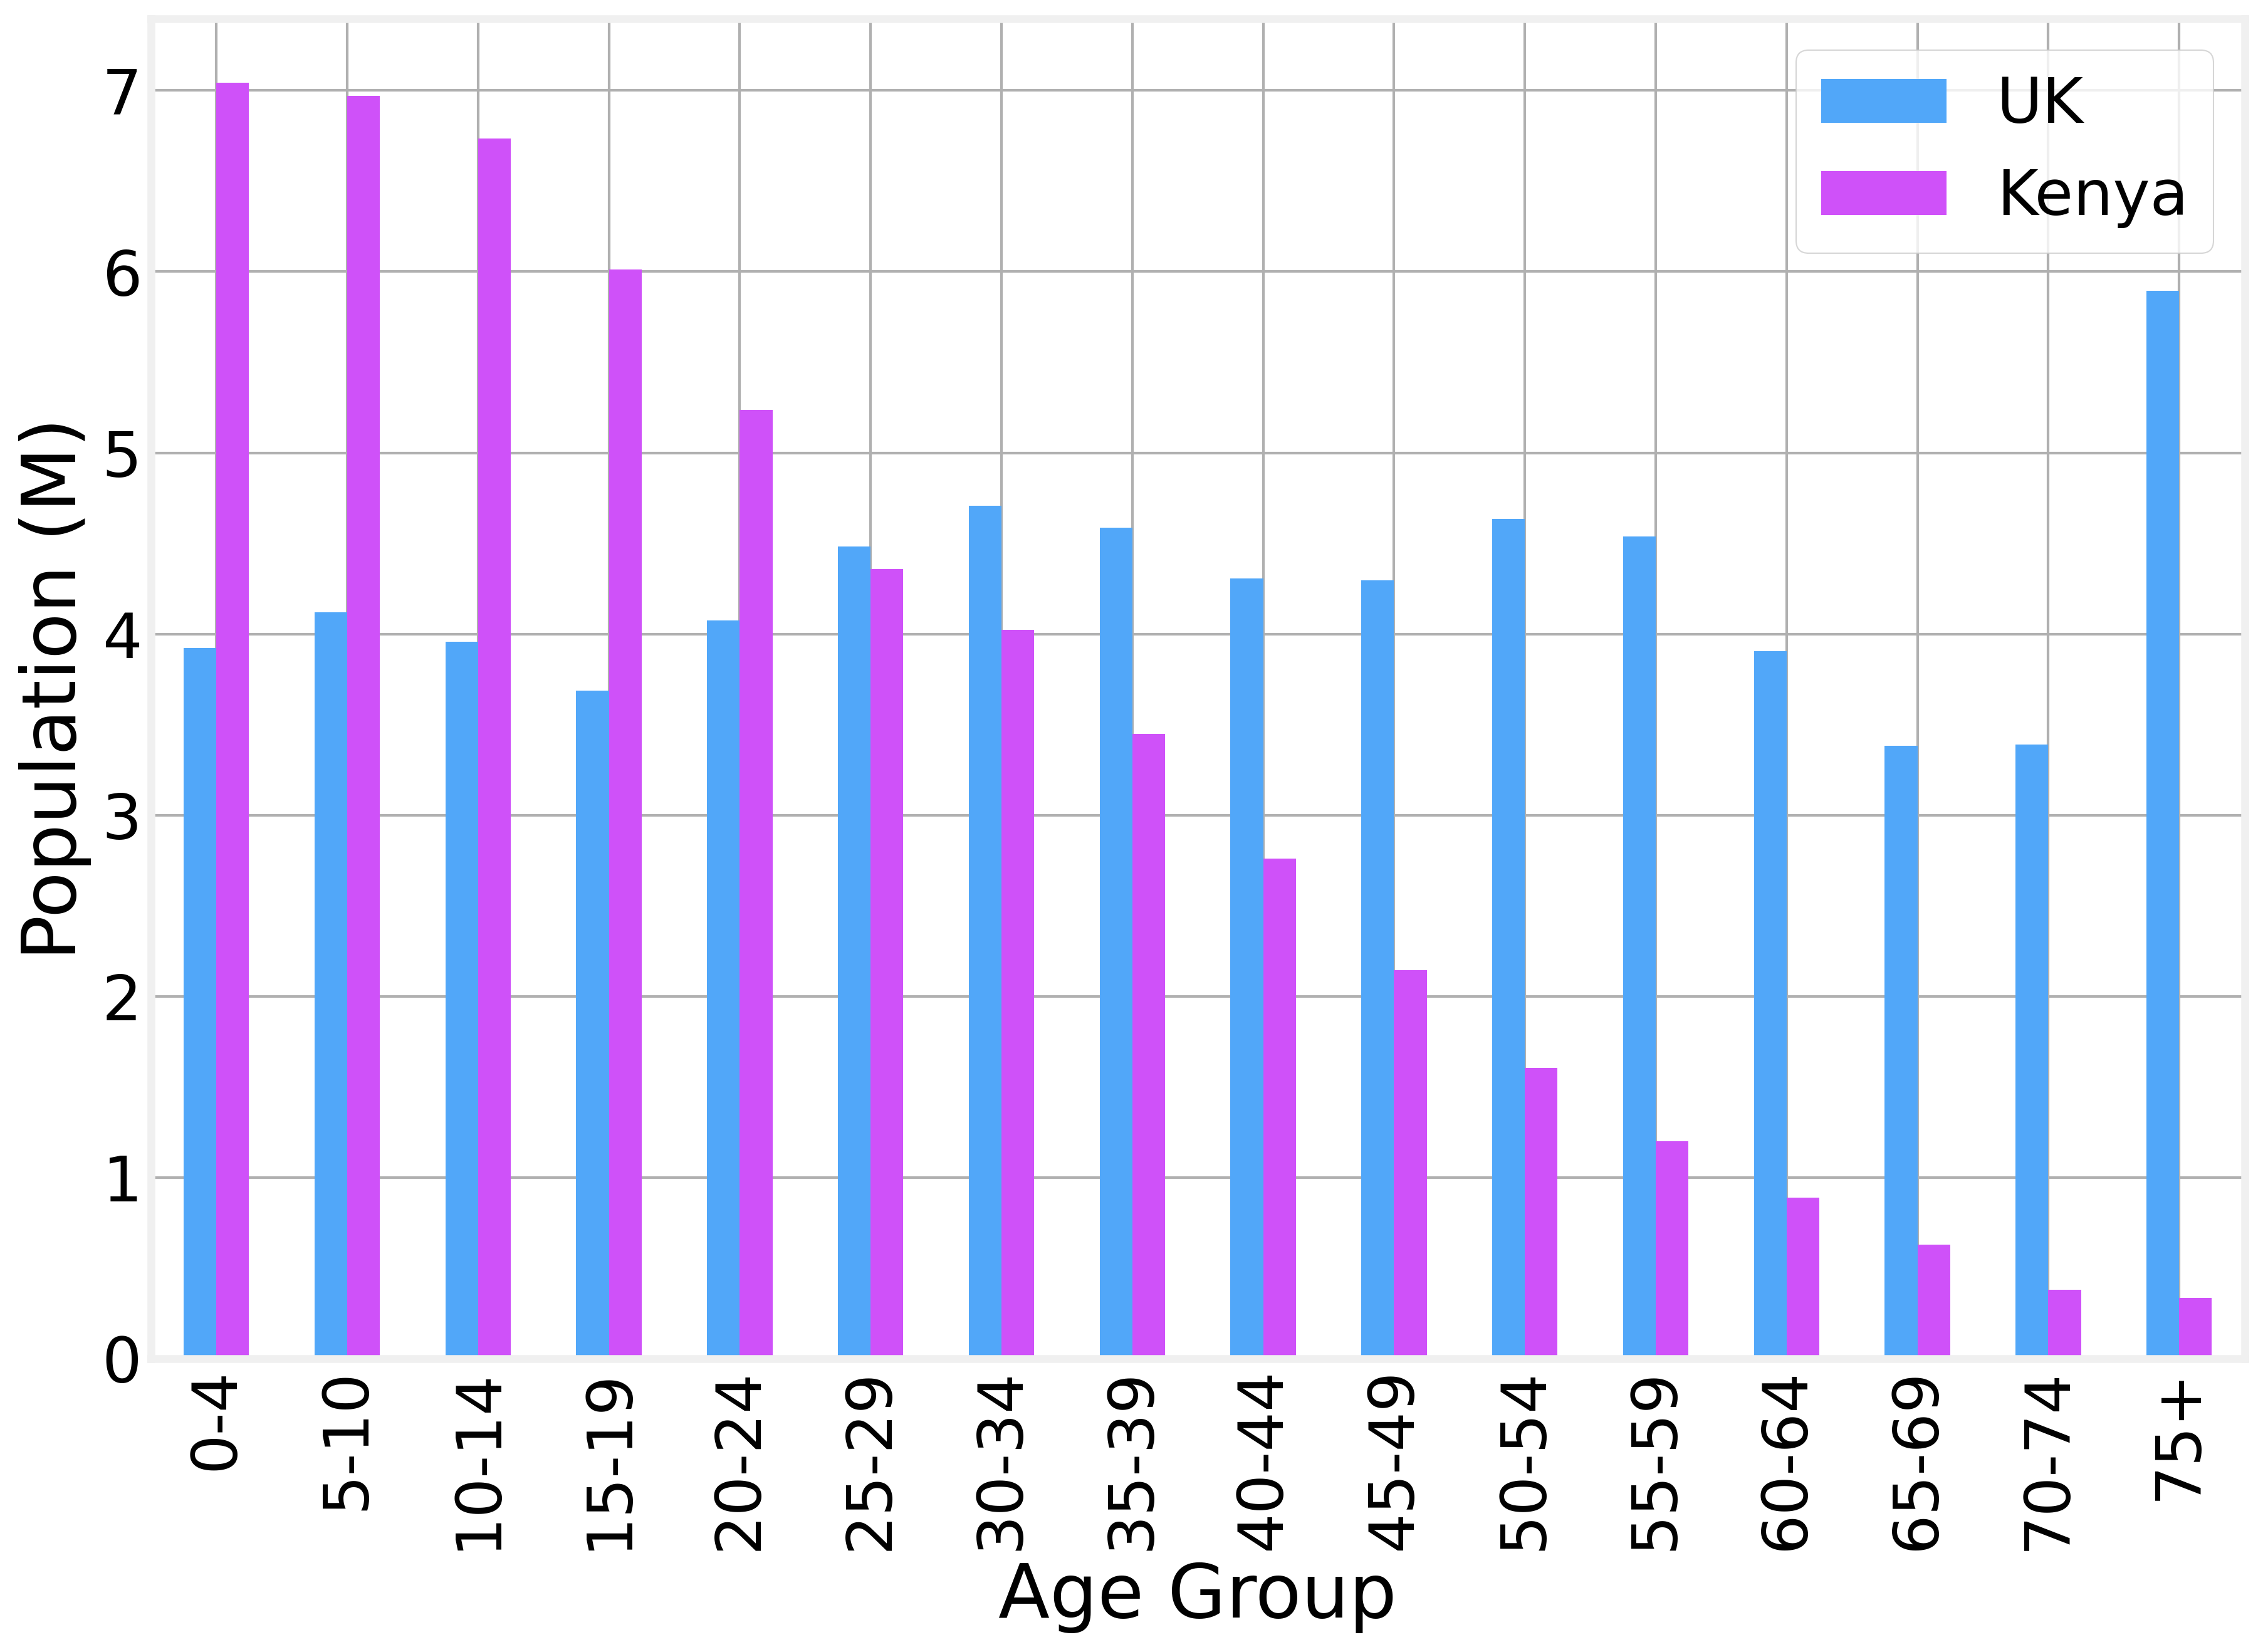

In [5]:
ax = (ages[['UK', 'Kenya']]/1e6).plot.bar()
ax.legend(['UK', 'Kenya'])
ax.set_xlabel('Age Group')
ax.set_ylabel('Population (M)')

despite having (relatively) comparable total populations

In [6]:
N_uk = int(Nk_uk.sum())
N_ke = int(Nk_ke.sum())

print("Total UK population:", N_uk)
print("Total Kenya population:", N_ke)

Total UK population: 67886004
Total Kenya population: 53771299


## Contact matrix

Next we load the contact matrices for each country. Each element of the matrix indicates the number of contacts between each pair of age groups. 

In [7]:
contacts_ke = pd.read_excel("data/MUestimates_all_locations_1.xlsx", sheet_name="Kenya")
contacts_ke.index=Ages
contacts_ke.columns=Ages

contacts_uk = pd.read_excel("data/MUestimates_all_locations_2.xlsx", sheet_name="United Kingdom of Great Britain", header=None)
contacts_uk.index=Ages
contacts_uk.columns=Ages

The differences in population structure we observed above are reflected here. The younger Kenyan population has many more contacts between younger age groups (along the main diagonal), while the older UK population has more inter generational connections, as seen in the two diagonals parallel to the main one.

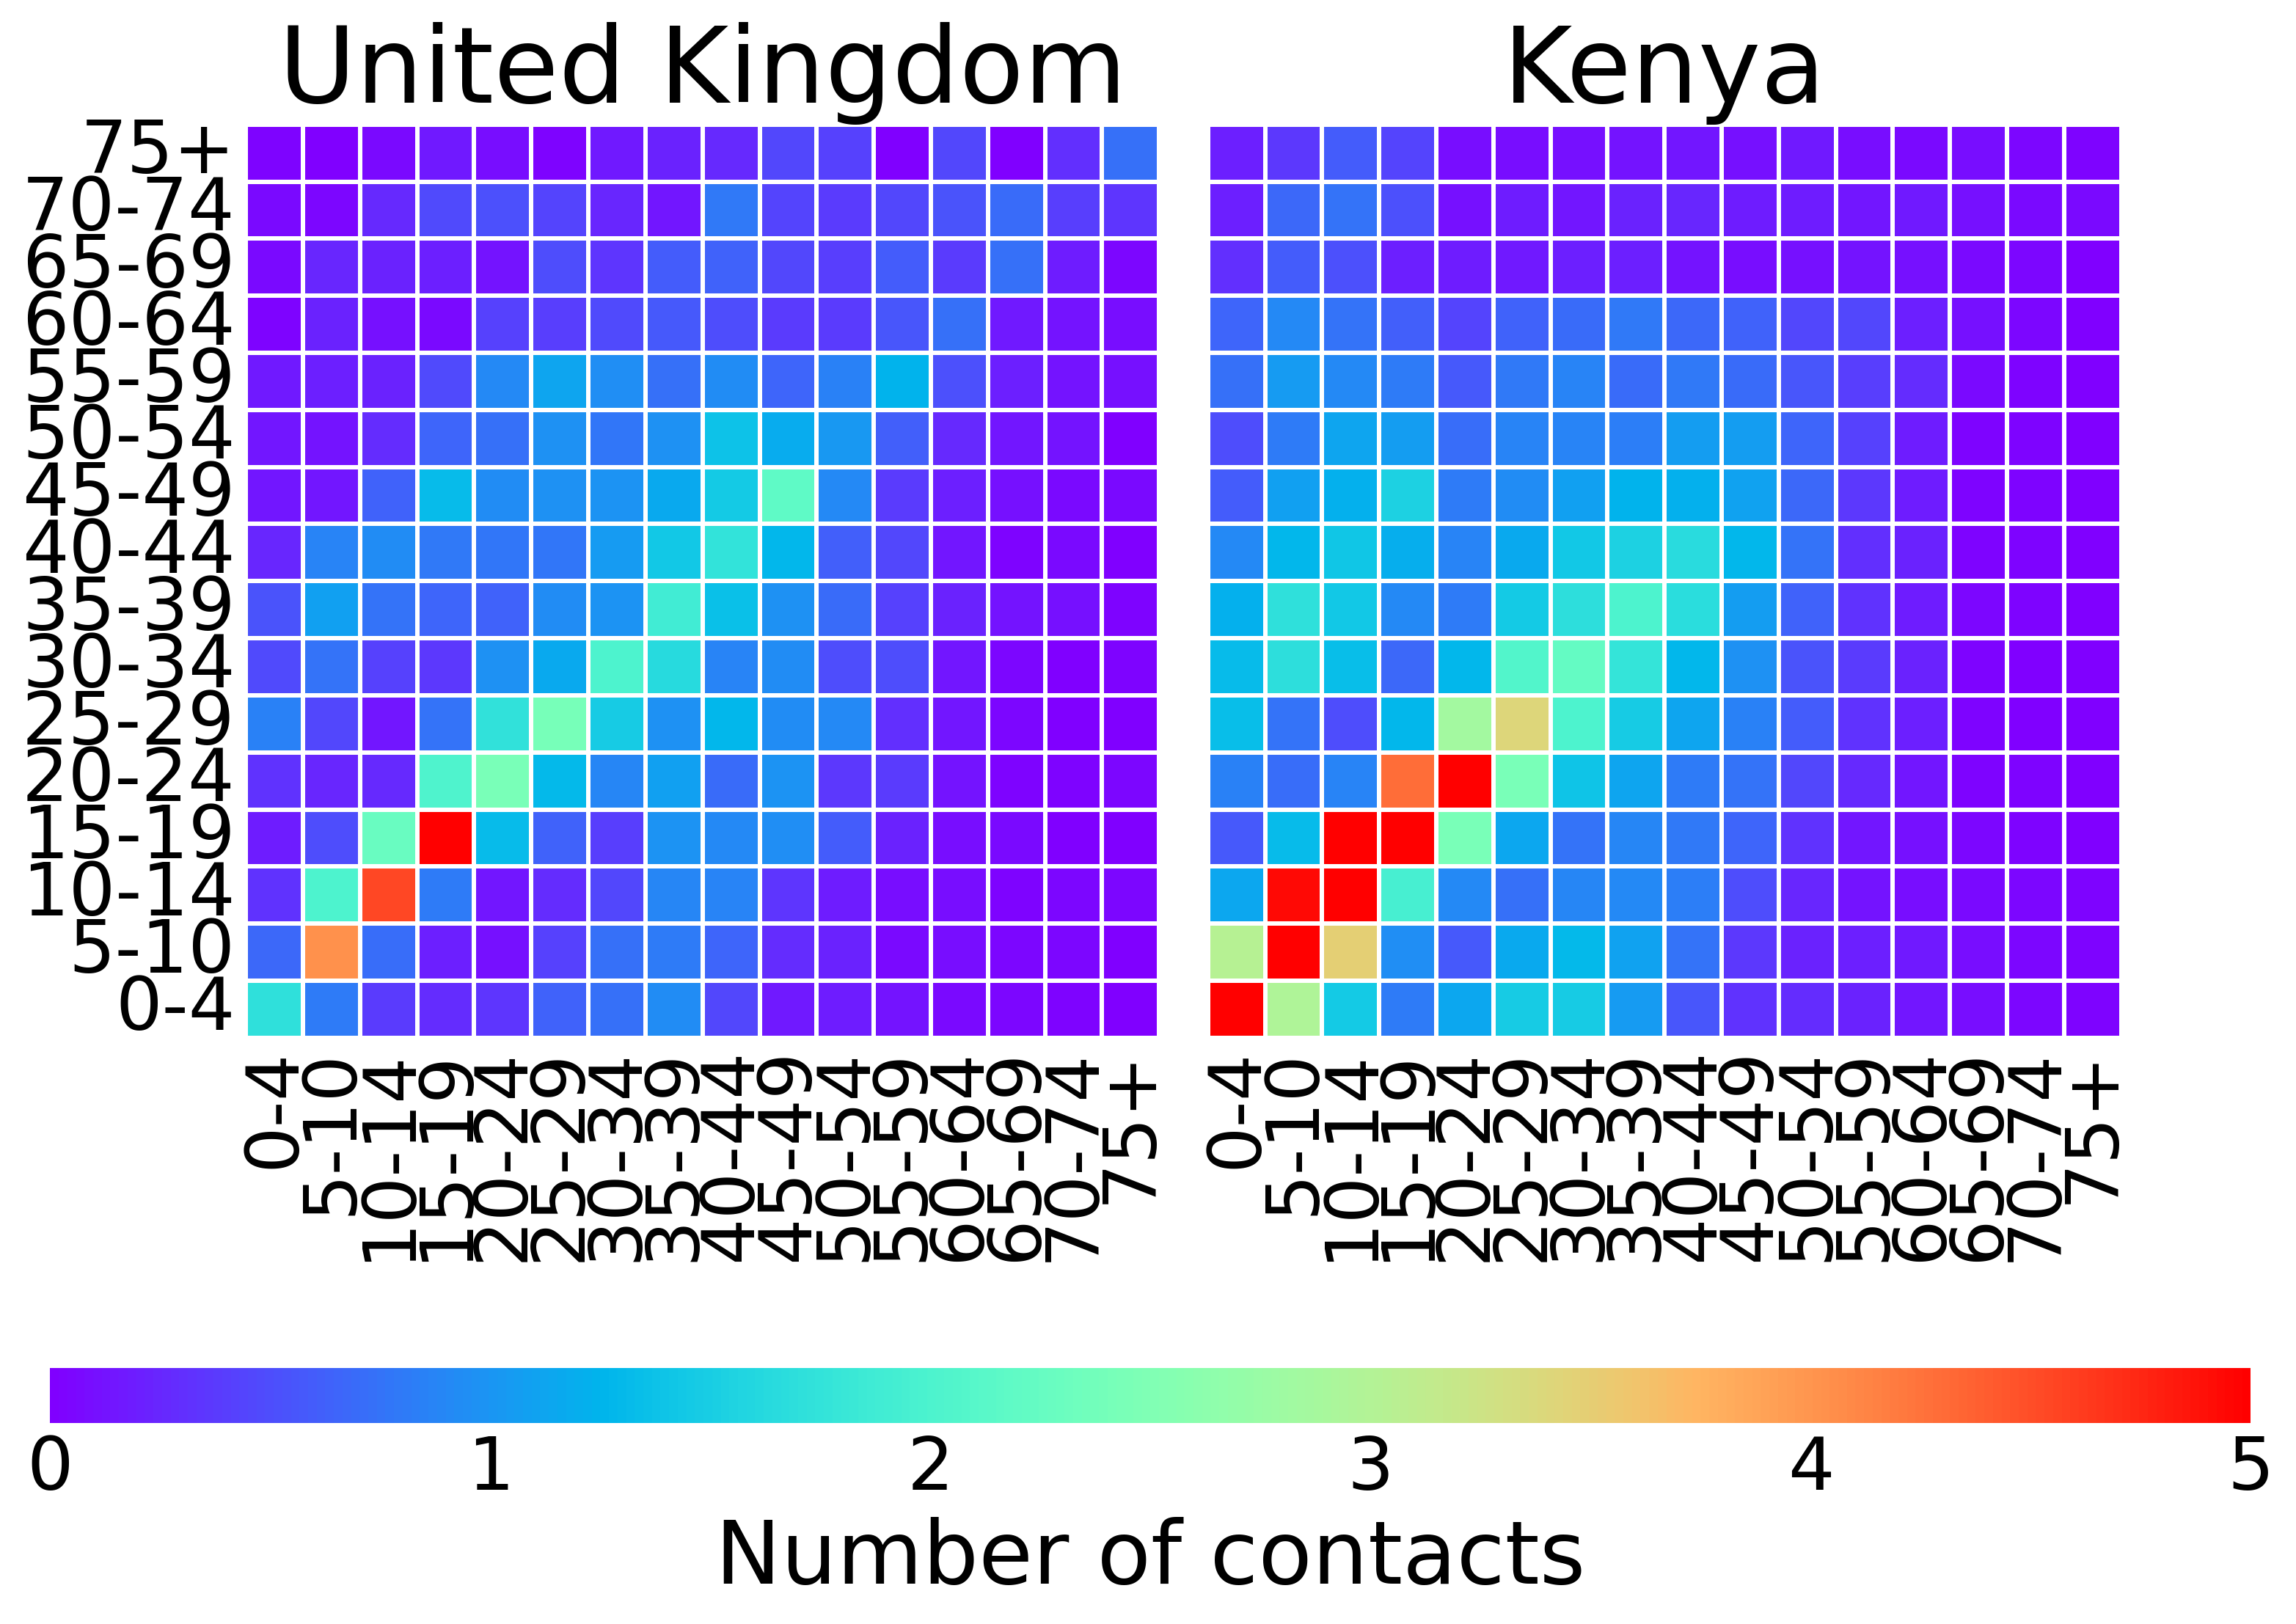

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0, -0.3, 1, 0.05])

sns.heatmap(contacts_uk[::-1], cmap=plt.cm.rainbow, ax=axs[0], vmin=0, vmax=5, 
            square=True, cbar=False, linewidth=1, linecolor='w',
            xticklabels=True, yticklabels=True)

sns.heatmap(contacts_ke[::-1], cmap=plt.cm.rainbow, ax=axs[1], vmin=0, vmax=5, 
            square=True, cbar_ax=cbar_ax, linewidth=1, linecolor='w',
            cbar_kws={'orientation':'horizontal', 
                      'label':'Number of contacts'},
            xticklabels=True, yticklabels=True)

axs[0].set_title('United Kingdom')
axs[1].set_title('Kenya')

fig.subplots_adjust(wspace=0.01)

# SIR Model with Age Structure

We start by setting up a regular SIR Model

In [9]:
beta = 0.05
mu = 0.1

SIR_uk = EpiModel()
SIR_uk.add_interaction('S', 'I', 'I', beta)
SIR_uk.add_spontaneous('I', 'R', mu)

With this choice of $\beta$ and $\mu$, the $R_0<1$ making an epidemic outbreak exponentially unlikely

In [10]:
print(SIR_uk)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.050000
I -> R 0.100000

R0=0.50


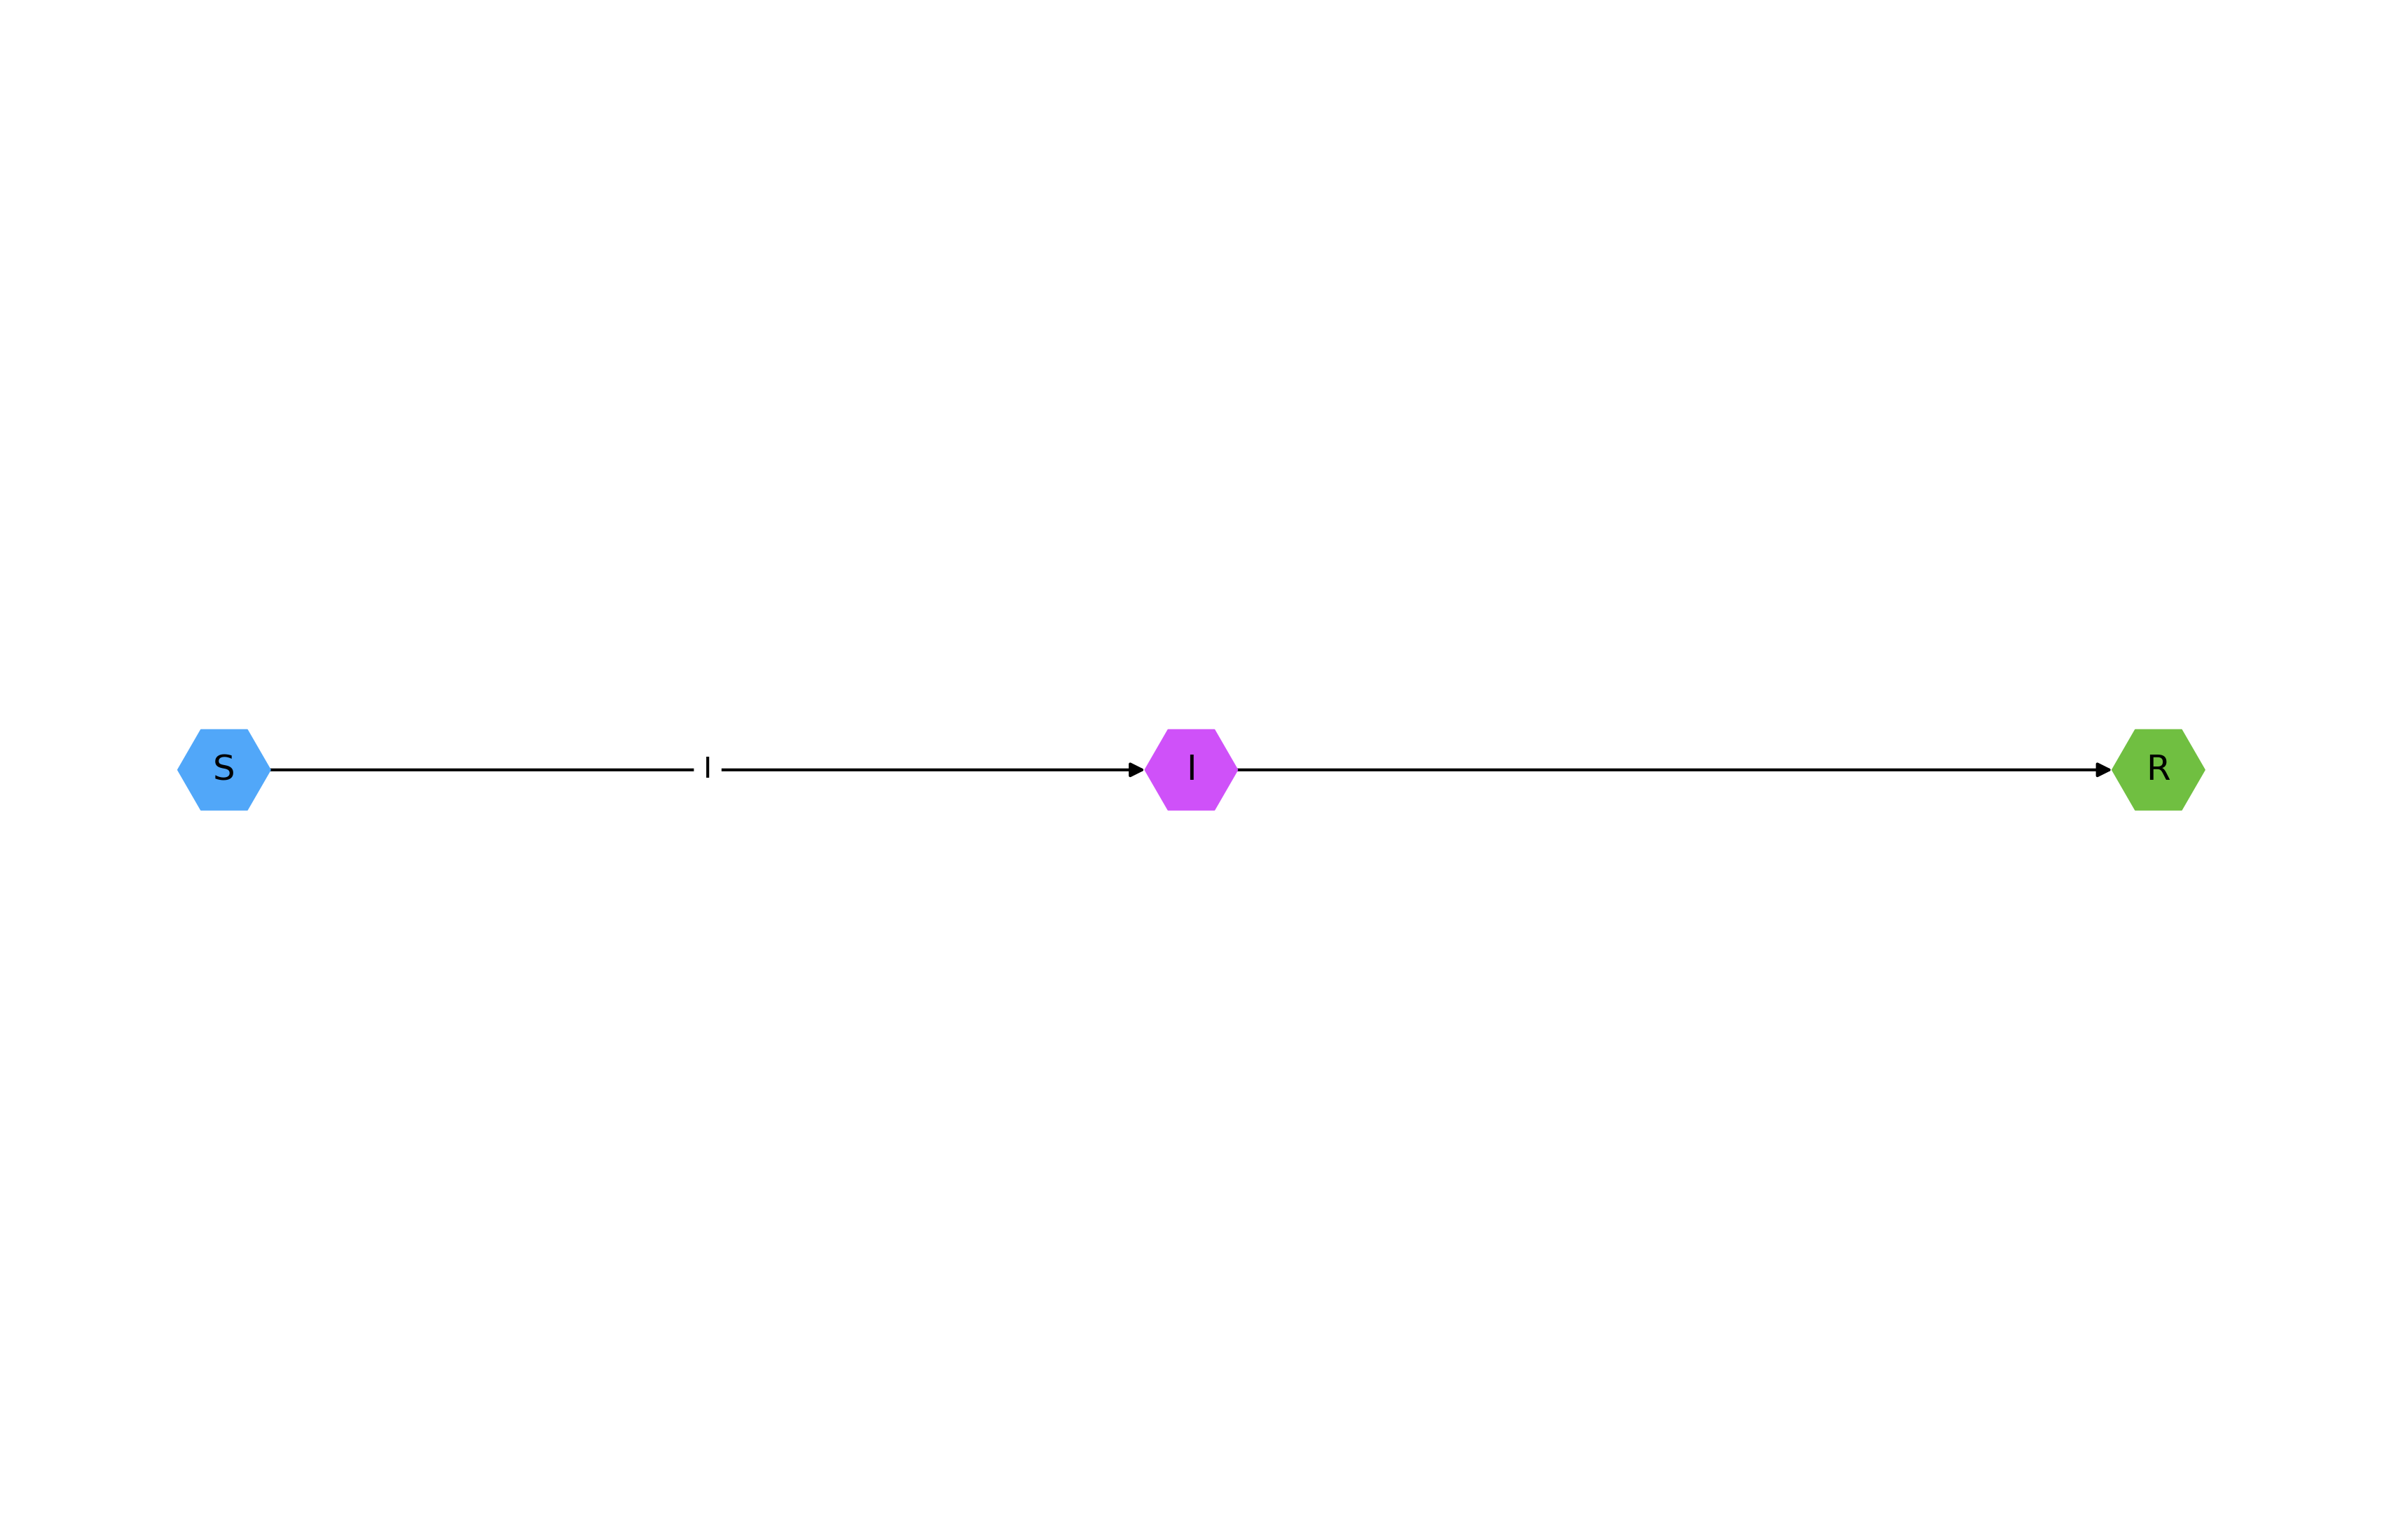

In [11]:
SIR_uk.draw_model()

We can add the details of the age structure by providing both the contact matrix and the population of each age group

In [12]:
SIR_uk.add_age_structure(contacts_uk, Nk_uk)

This adds all the necessary compartments and transitions:

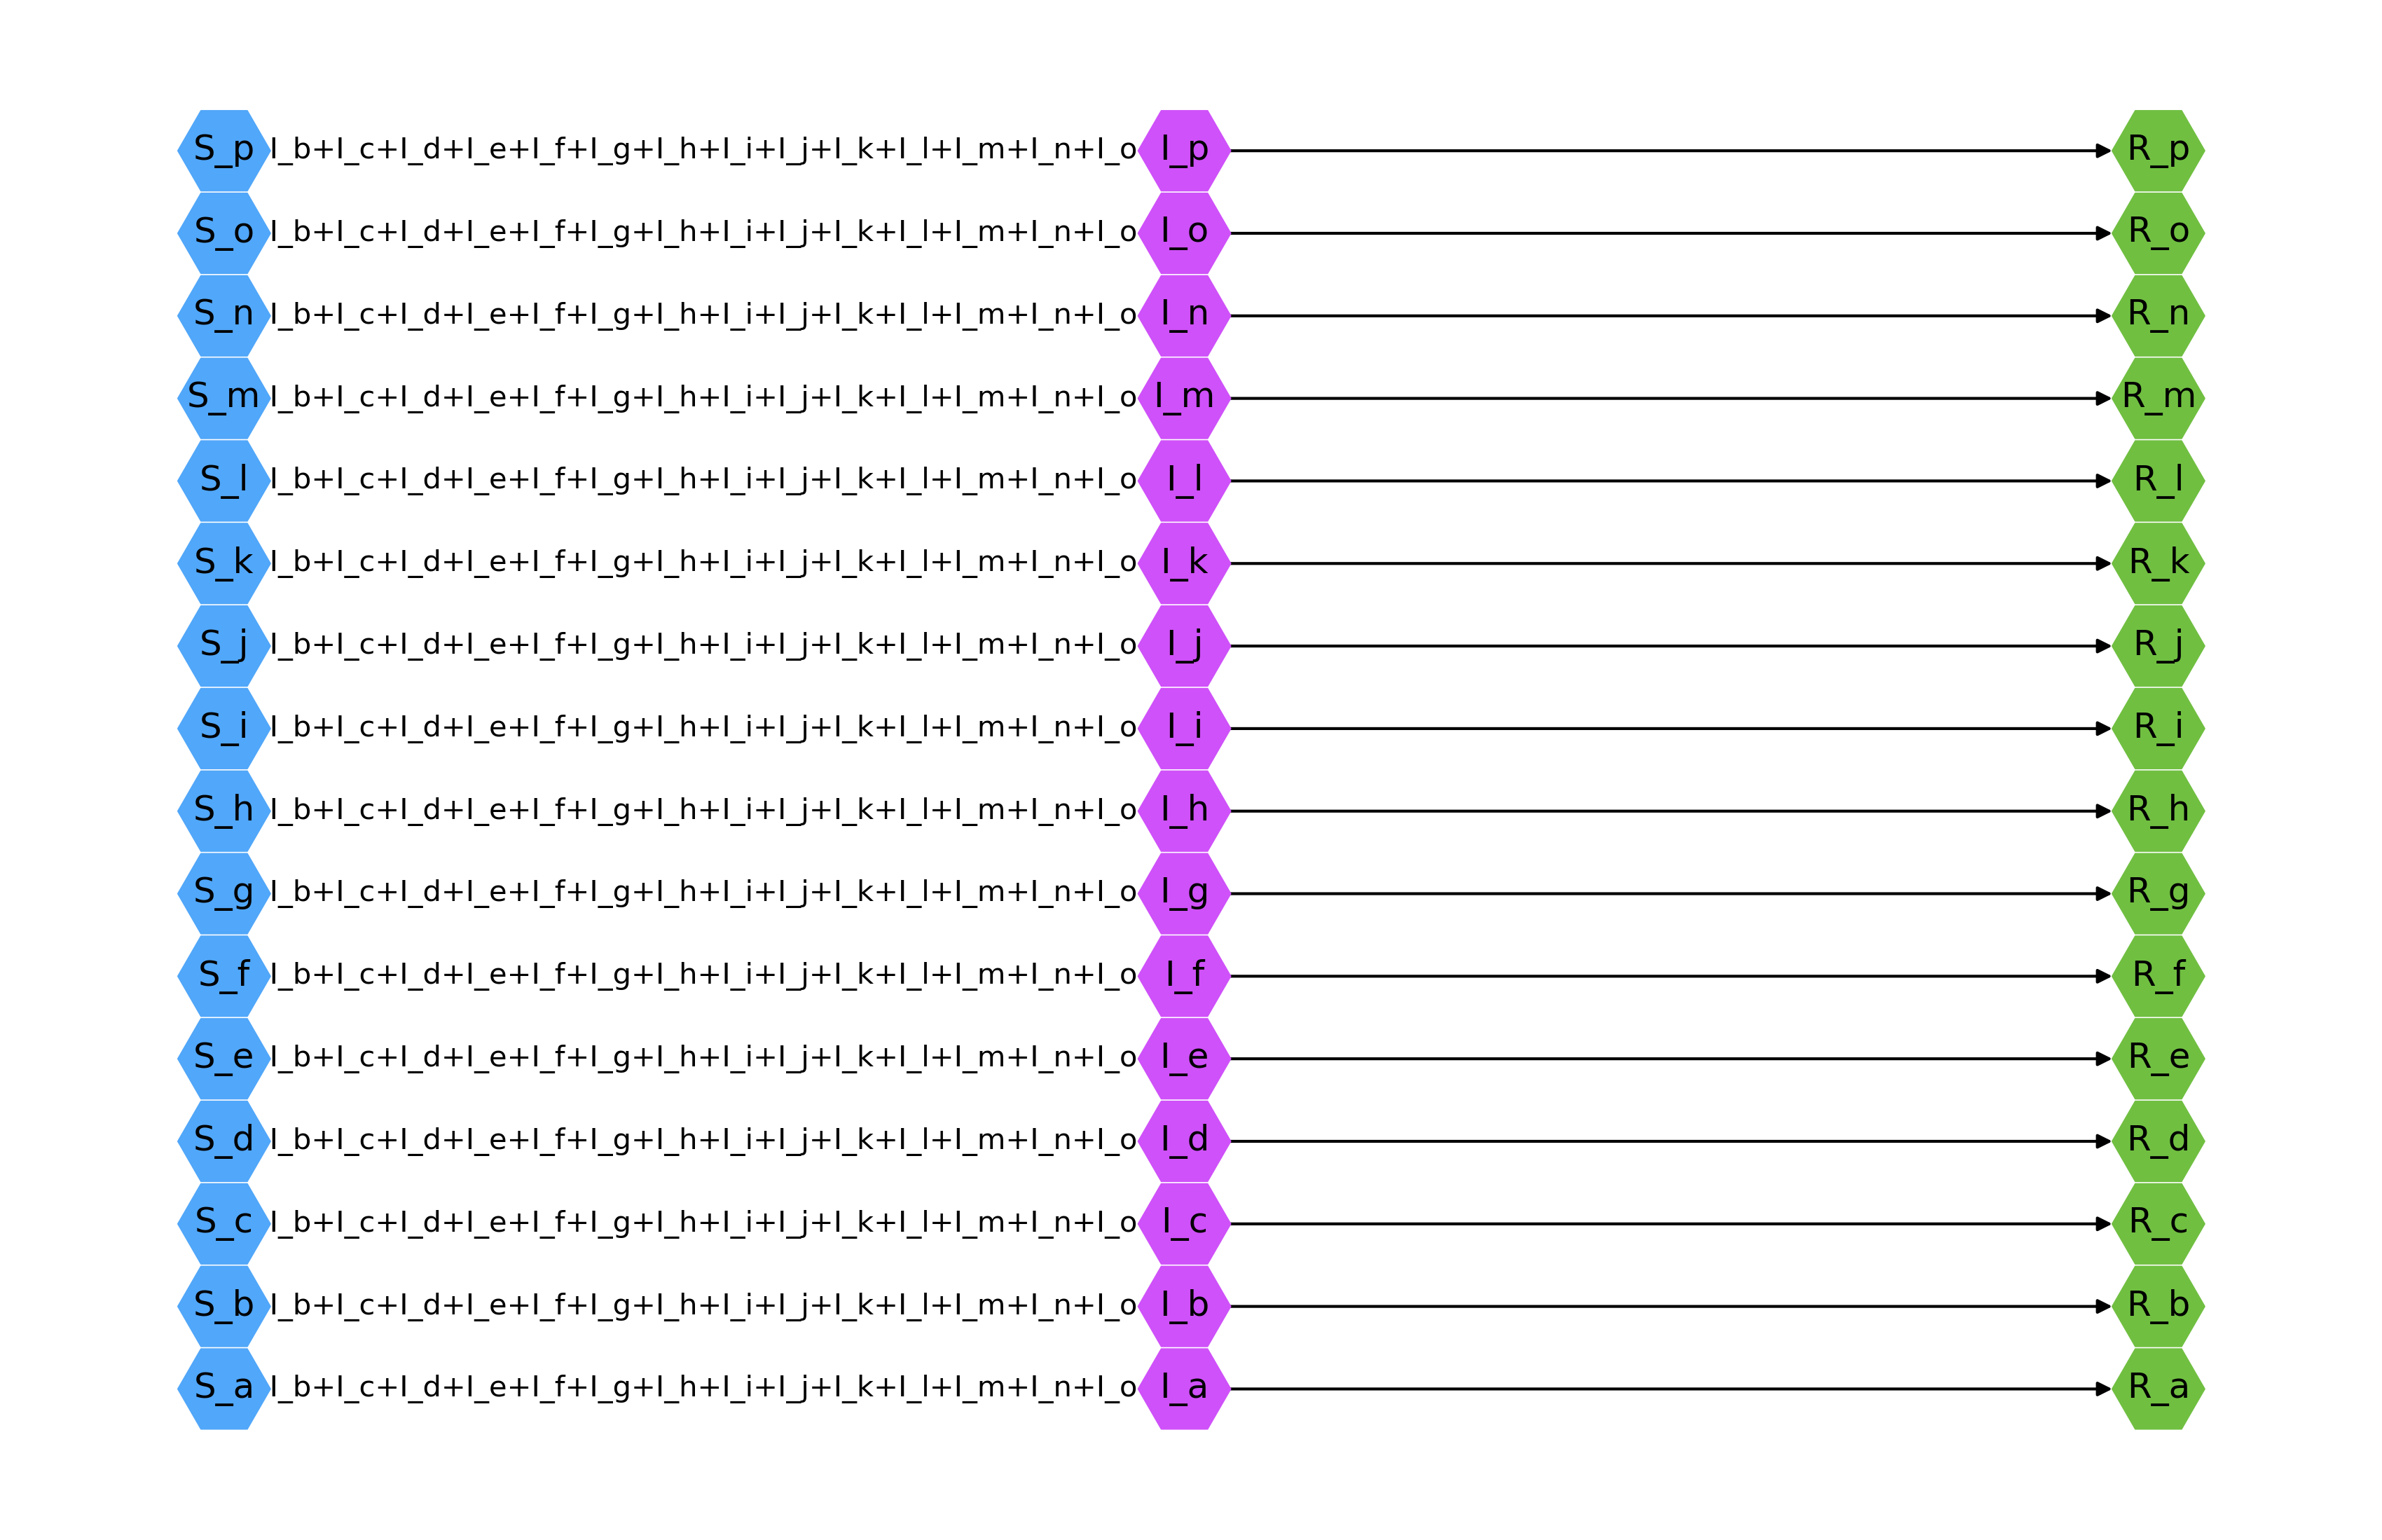

In [13]:
SIR_uk.draw_model()

Resulting in an increased value of $R_0$.

In [14]:
R0_uk = SIR_uk.R0()
R0_uk

5.839713803900266

The increased $R_0$ can be accounted for by the added level of interactions between the various subpopulations. In fact, if we take the largest eigenvalue of the contact matrix:

In [15]:
lmax = np.max(np.real(np.linalg.eig(contacts_uk)[0]))
lmax

11.679427607800536

We can recover the original value of $R_0$:

In [16]:
SIR_uk.R0()/lmax

0.49999999999999983

We can integrate the model as usual:

In [17]:
SIR_uk.integrate(100, S=N_uk*.99, I=N_uk*.01, R=0)

And by default, the `plot()` method, plots the totals for the original compartments

<Axes: title={'center': 'United Kingdom'}, xlabel='Time', ylabel='Population'>

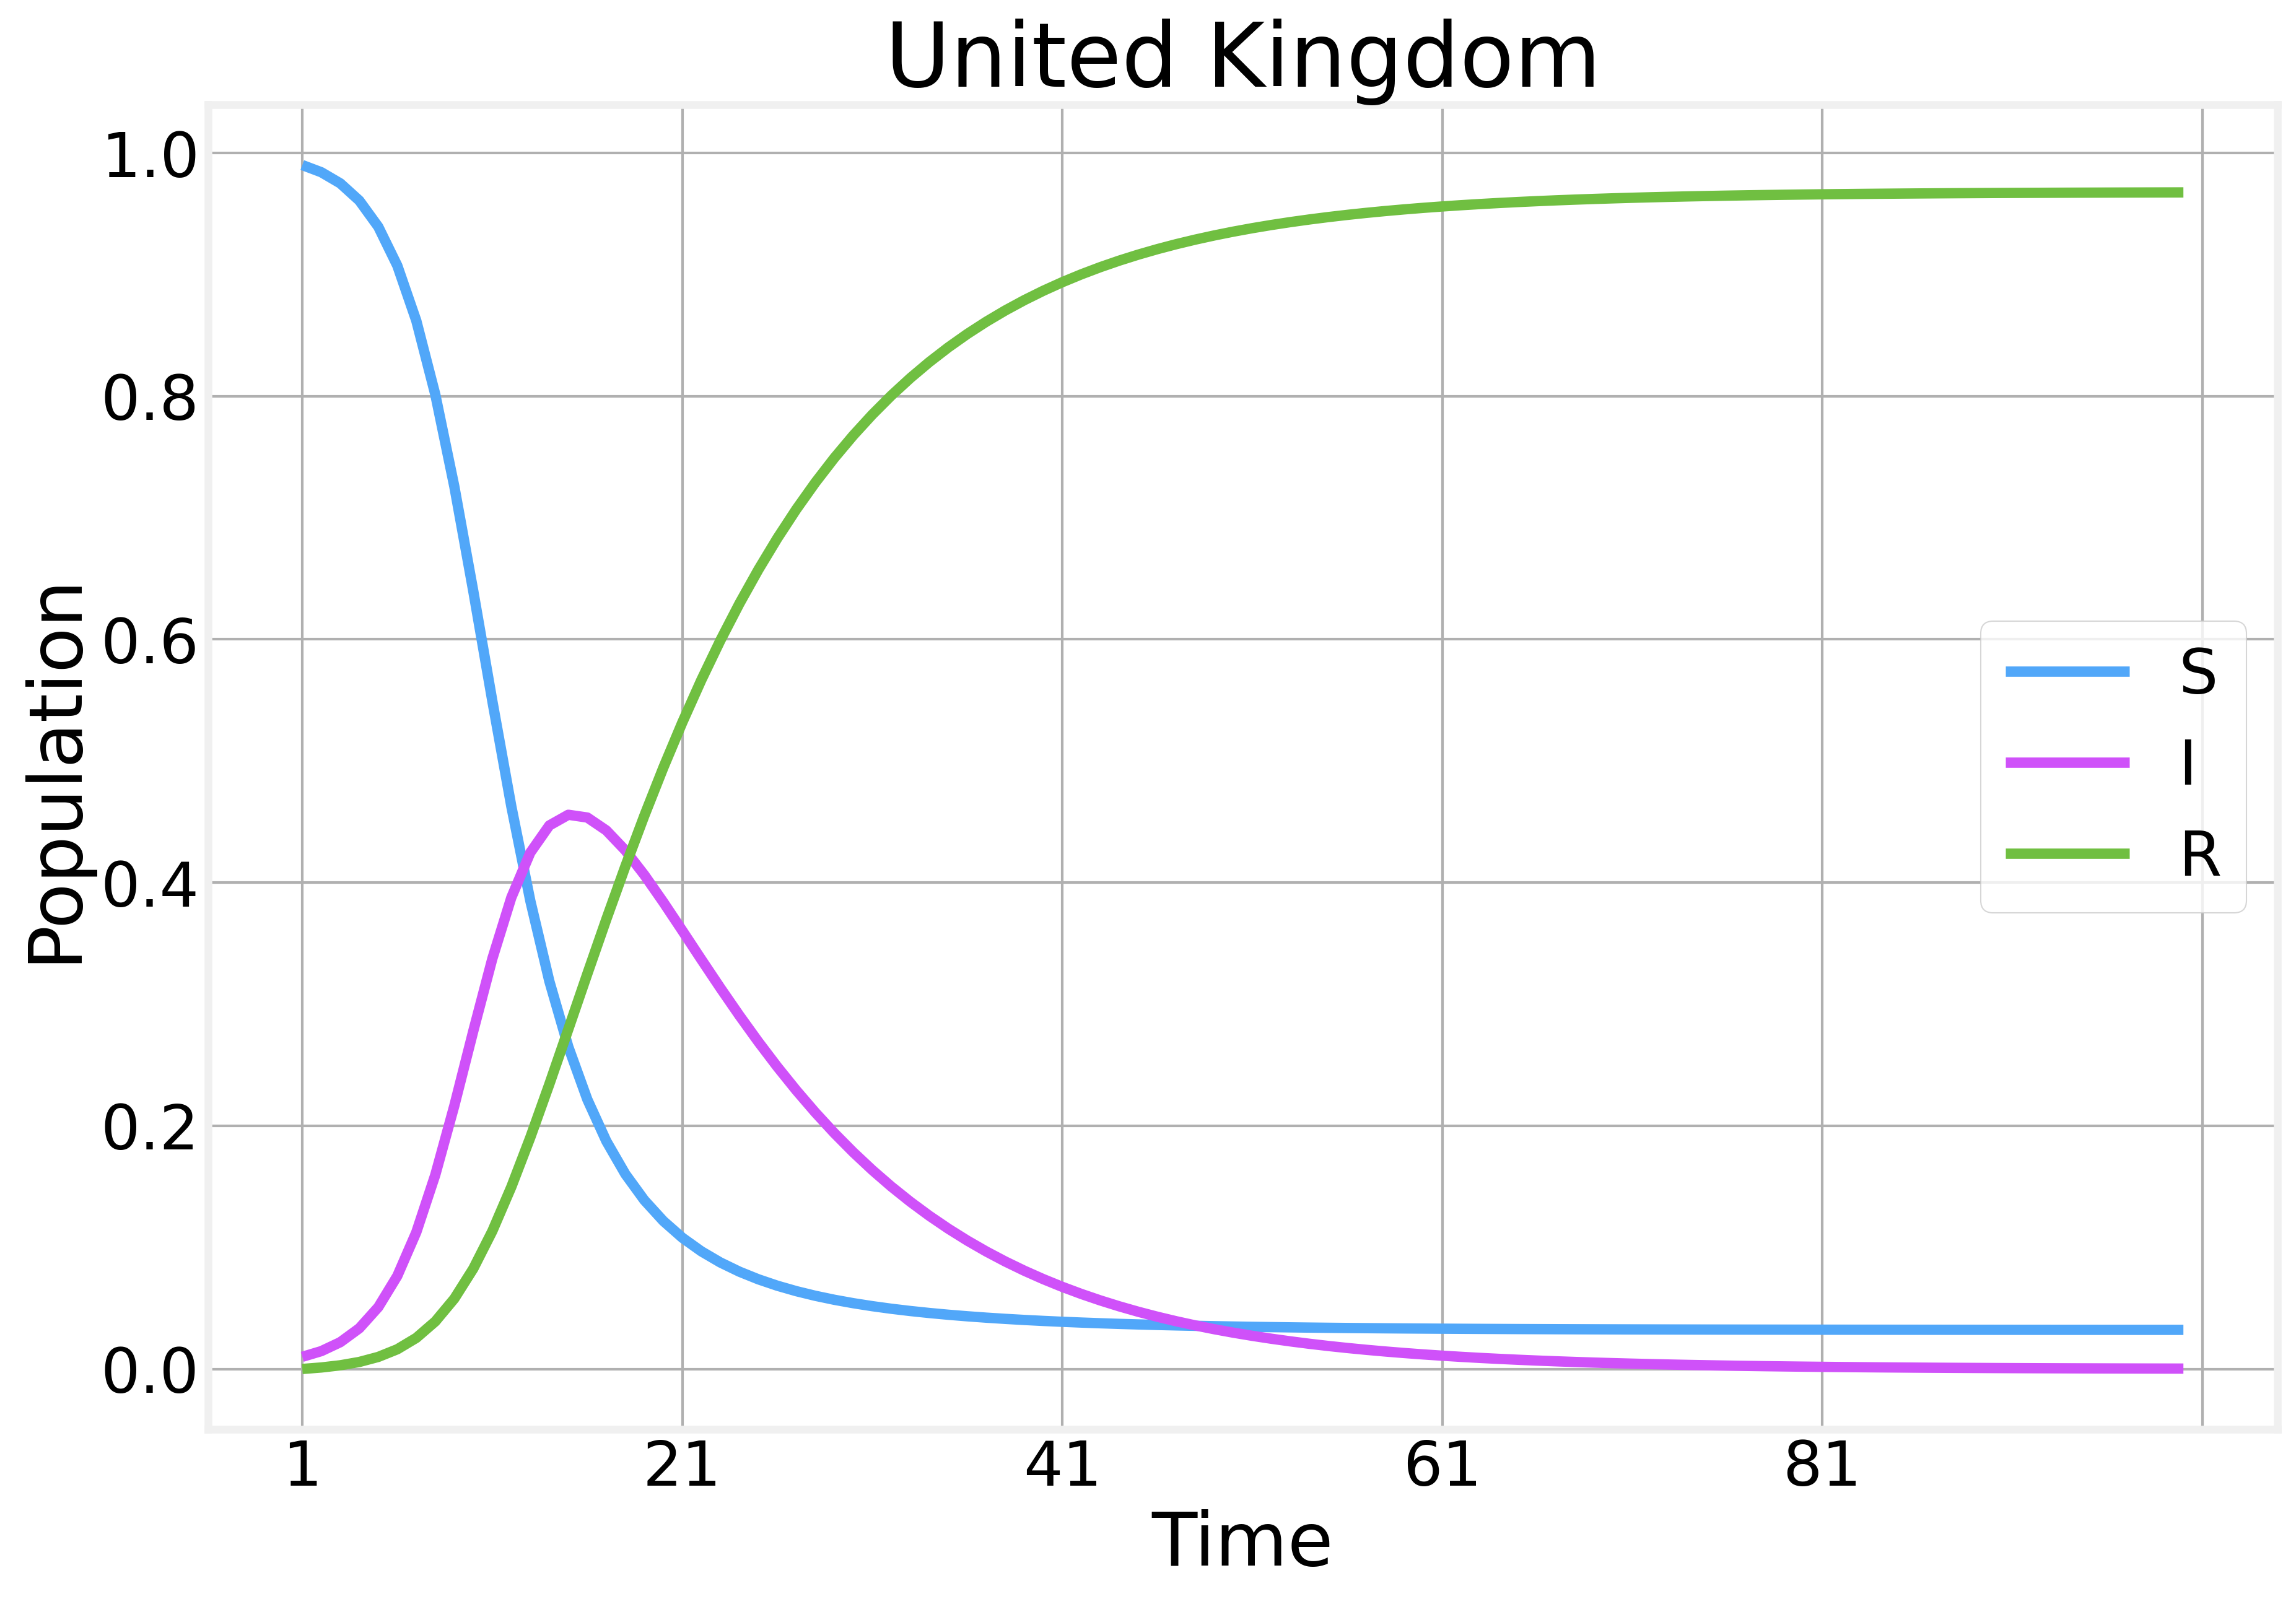

In [18]:
SIR_uk.plot(title='United Kingdom')

The values for each compartment are available in the `values_ages_` field

In [19]:
SIR_uk.values_ages_

S_a            I_a           S_b            I_b           S_c  \
1    3.886713e+06   39395.000000  4.078431e+06   41510.000000  3.916754e+06   
2    3.870150e+06   51460.625423  4.055435e+06   59515.557002  3.889302e+06   
3    3.845268e+06   70322.480449  4.021193e+06   86545.261077  3.846921e+06   
4    3.807658e+06   99544.144164  3.970013e+06  127176.506780  3.781967e+06   
5    3.750982e+06  144187.948112  3.893807e+06  187831.271304  3.683837e+06   
..            ...            ...           ...            ...           ...   
96   1.279688e+05    2044.700134  4.384825e+04    1500.456397  1.569978e+04   
97   1.279540e+05    1864.181949  4.384176e+04    1363.848375  1.569729e+04   
98   1.279406e+05    1699.565841  4.383585e+04    1239.676181  1.569503e+04   
99   1.279284e+05    1549.454519  4.383048e+04    1126.807963  1.569297e+04   
100  1.279173e+05    1412.573100  4.382561e+04    1024.214852  1.569111e+04   

               I_c           S_d            I_d           S_e            I_e  \
1     39855.000000  3.651070e+06   36724.000000  4.033665e+06   40212.000000   
2     62280.675372  3.609614e+06   72859.499780  4.004609e+06   64147.118343   
3     96829.547111  3.539405e+06  133020.010924  3.957801e+06  102759.610496   
4    149643.587315  3.425184e+06  229478.749019  3.883656e+06  163802.995459   
5    229099.377501  3.247617e+06  377202.970489  3.769021e+06  257687.320398   
..             ...           ...            ...           ...            ...   
96     1081.663261  7.648464e+02     655.975735  1.537066e+04    1048.699225   
97      981.099267  7.646994e+02     593.691178  1.536843e+04     951.022174   
98      889.887015  7.645661e+02     537.320724  1.536641e+04     862.444292   
99      807.156692  7.644453e+02     486.302795  1.536457e+04     782.117838   
100     732.119397  7.643357e+02     440.129136  1.536291e+04     709.274056   

     ...           R_g           R_h           R_i           R_j  \
1    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    ...  5.914908e+03  5.824581e+03  5.484521e+03  5.504426e+03   
3    ...  1.503441e+04  1.496535e+04  1.405941e+04  1.431722e+04   
4    ...  2.908012e+04  2.918253e+04  2.742409e+04  2.831067e+04   
5    ...  5.061785e+04  5.109960e+04  4.810984e+04  5.027738e+04   
..   ...           ...           ...           ...           ...   
96   ...  4.686281e+06  4.574408e+06  4.288115e+06  4.281641e+06   
97   ...  4.686407e+06  4.574526e+06  4.288225e+06  4.281744e+06   
98   ...  4.686522e+06  4.574632e+06  4.288325e+06  4.281838e+06   
99   ...  4.686626e+06  4.574728e+06  4.288415e+06  4.281923e+06   
100  ...  4.686721e+06  4.574816e+06  4.288497e+06  4.281999e+06   

              R_k           R_l           R_m           R_n           R_o  \
1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    5.605340e+03  5.491217e+03  4.217068e+03  3.753831e+03  3.811909e+03   
3    1.393853e+04  1.359165e+04  9.473565e+03  8.529999e+03  8.752976e+03   
4    2.654019e+04  2.571707e+04  1.639171e+04  1.492619e+04  1.546821e+04   
5    4.572269e+04  4.399867e+04  2.591381e+04  2.384765e+04  2.494388e+04   
..            ...           ...           ...           ...           ...   
96   4.589298e+06  4.494135e+06  3.601389e+06  3.176916e+06  3.222333e+06   
97   4.589443e+06  4.494282e+06  3.601664e+06  3.177132e+06  3.222543e+06   
98   4.589576e+06  4.494416e+06  3.601915e+06  3.177329e+06  3.222734e+06   
99   4.589696e+06  4.494538e+06  3.602144e+06  3.177510e+06  3.222909e+06   
100  4.589805e+06  4.494649e+06  3.602354e+06  3.177675e+06  3.223069e+06   

              R_p  
1    0.000000e+00  
2    6.139149e+03  
3    1.305479e+04  
4    2.129192e+04  
5    3.168422e+04  
..            ...  
96   4.728367e+06  
97   4.729053e+06  
98   4.729684e+06  
99   4.730264e+06  
100  4.730797e+06  

[100 rows x 48 columns]

So we can also visualize the number of infected in each age group:

In [20]:
infected_compartments = [col for col in SIR_uk.values_ages_.columns if col[0]=='I']

Text(0.5, 1.0, 'United Kingdom')

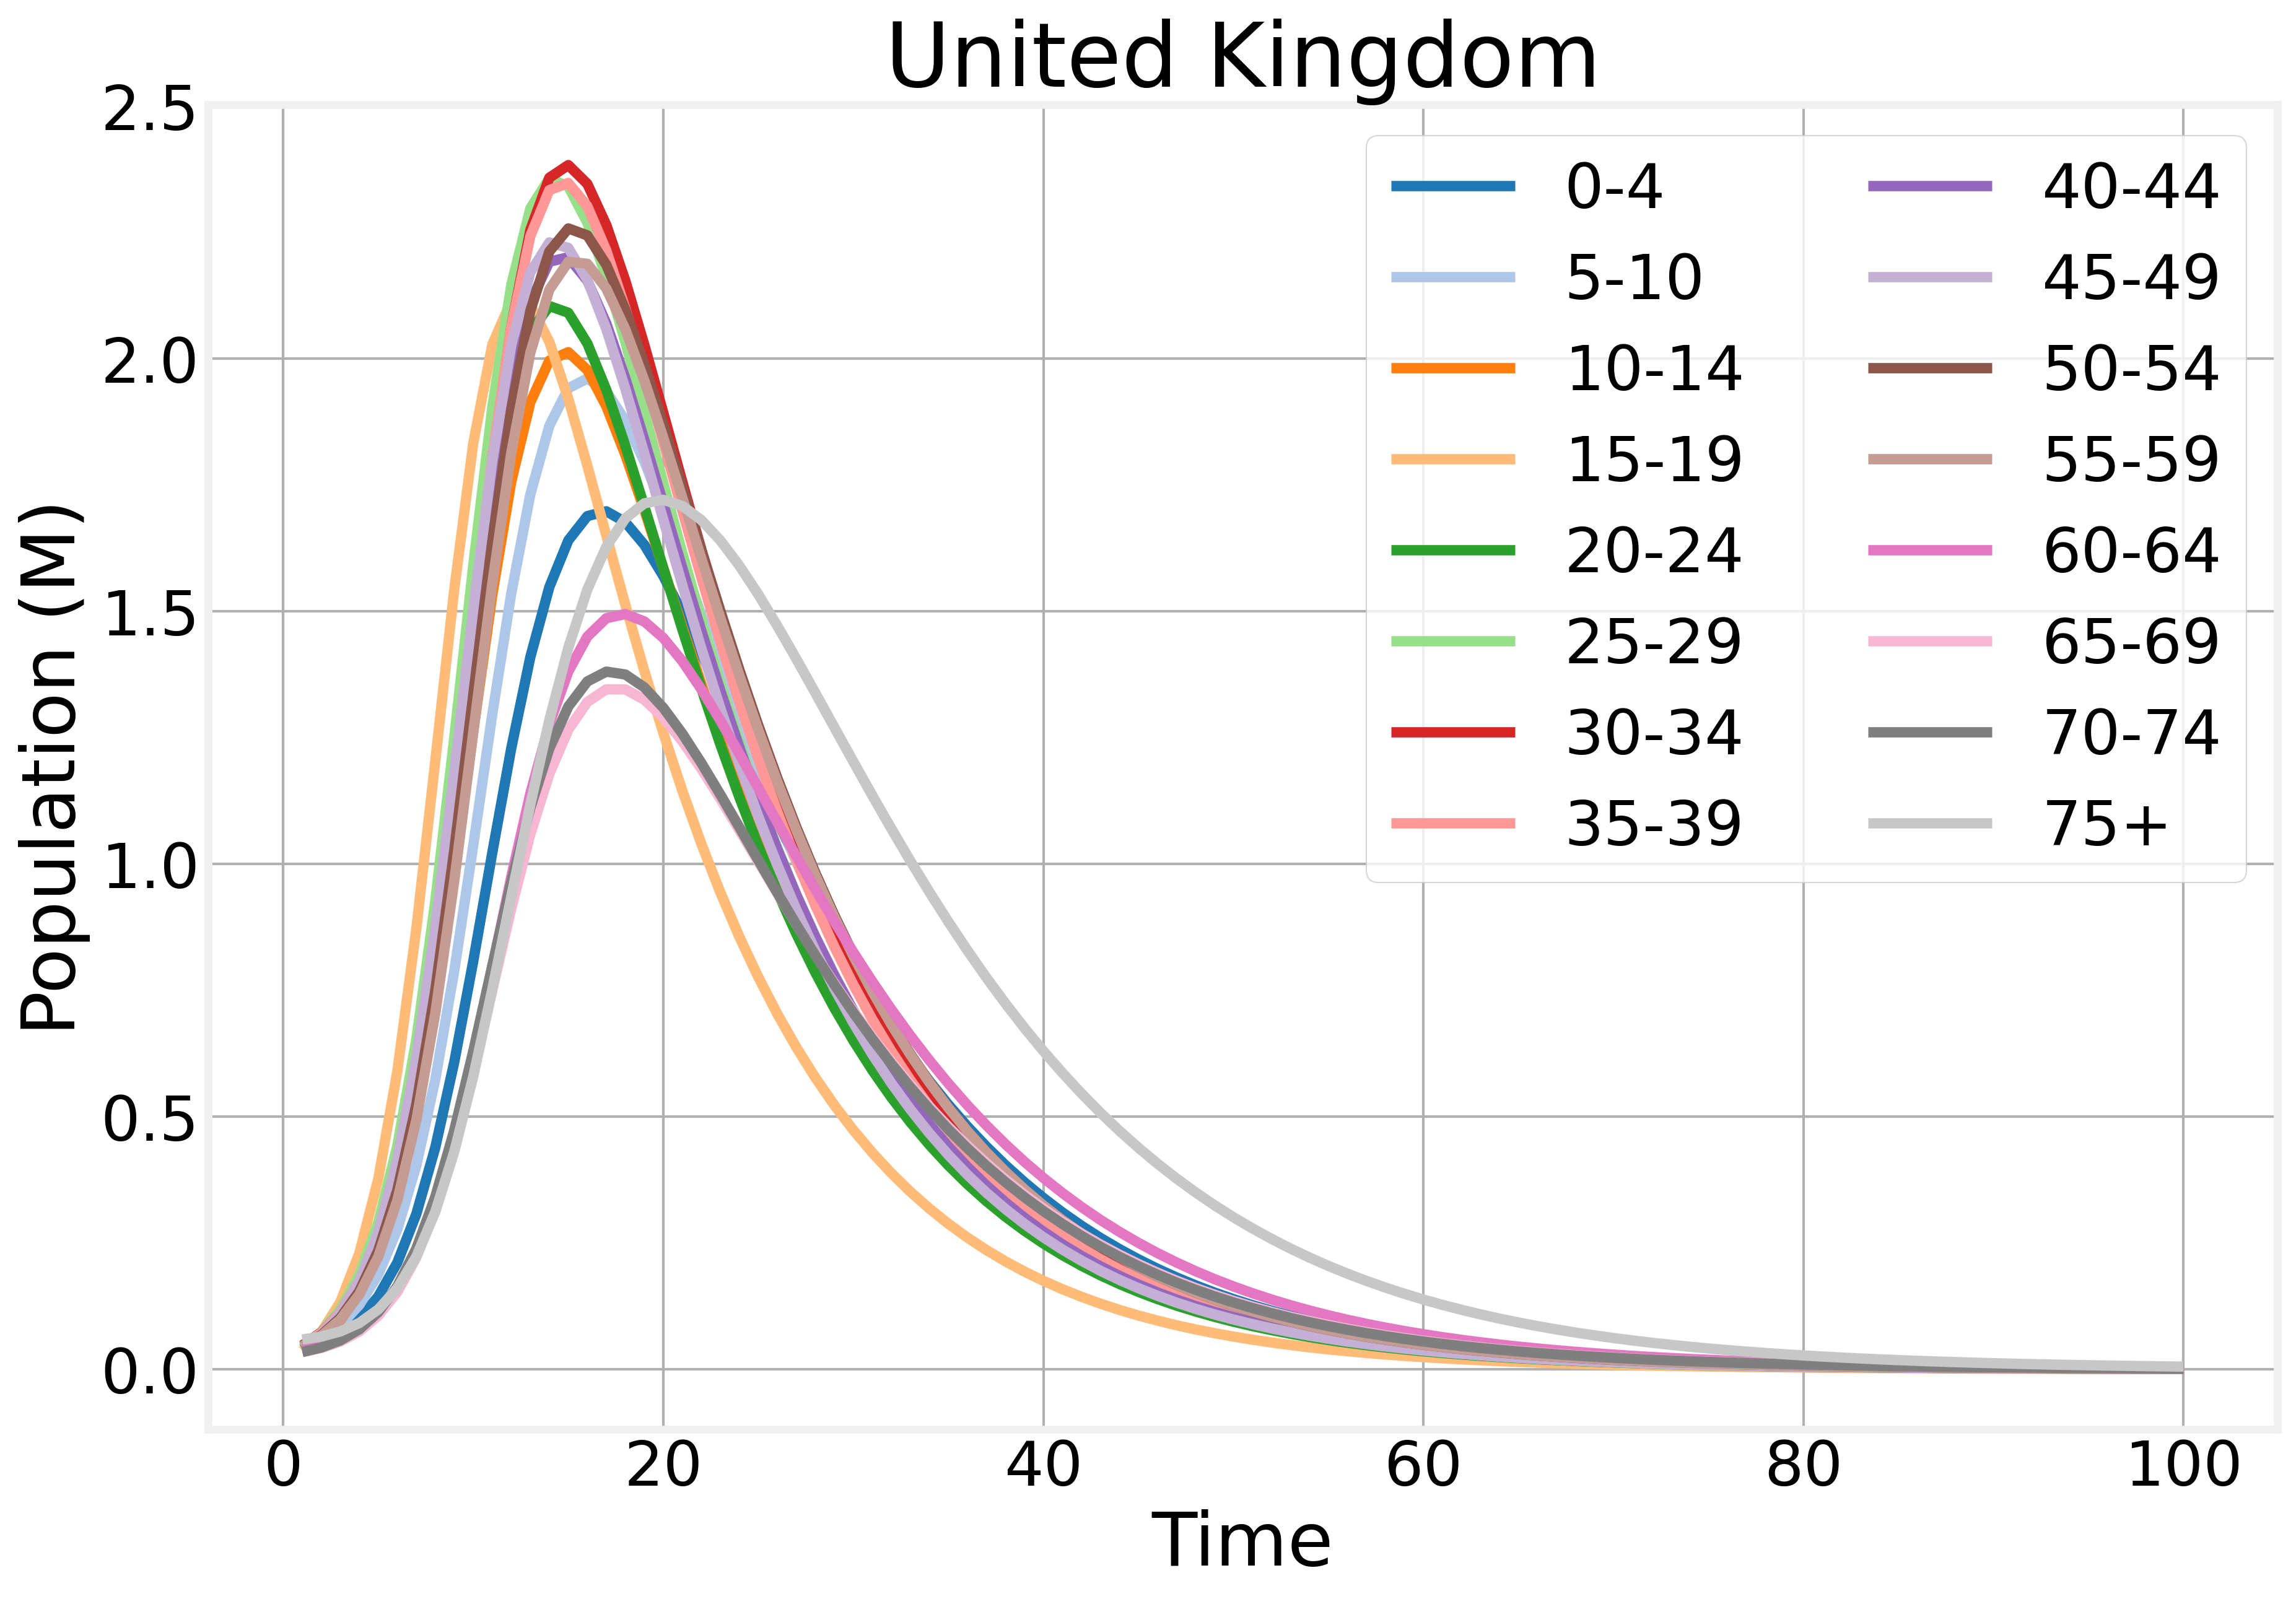

In [21]:
fig, ax = plt.subplots(1)
(SIR_uk.values_ages_[infected_compartments]/1e6).plot(ax=ax, color=plt.cm.tab20(np.arange(16)))
ax.legend(Ages, loc='upper right', ncols=2)
ax.set_xlabel('Time')
ax.set_ylabel('Population (M)')
ax.set_title('United Kingdom')

# Impact of the Age Structure

Let us define a similar SIR model for Kenya

In [22]:
SIR_ke = EpiModel()
SIR_ke.add_interaction('S', 'I', 'I', beta)
SIR_ke.add_spontaneous('I', 'R', mu)

And add the age structure

In [23]:
SIR_ke.add_age_structure(contacts_ke, Nk_ke)

Differences in the contact structur between the UK and Kenya result in a different value of the final $R_0$:

In [24]:
R0_ke = SIR_ke.R0()
R0_ke

11.57835547375836

Integrating

In [25]:
SIR_ke.integrate(100, S=N_uk*.99, I=N_uk*.01, R=0)

we obtain:

Text(0.5, 1.0, 'Kenya')

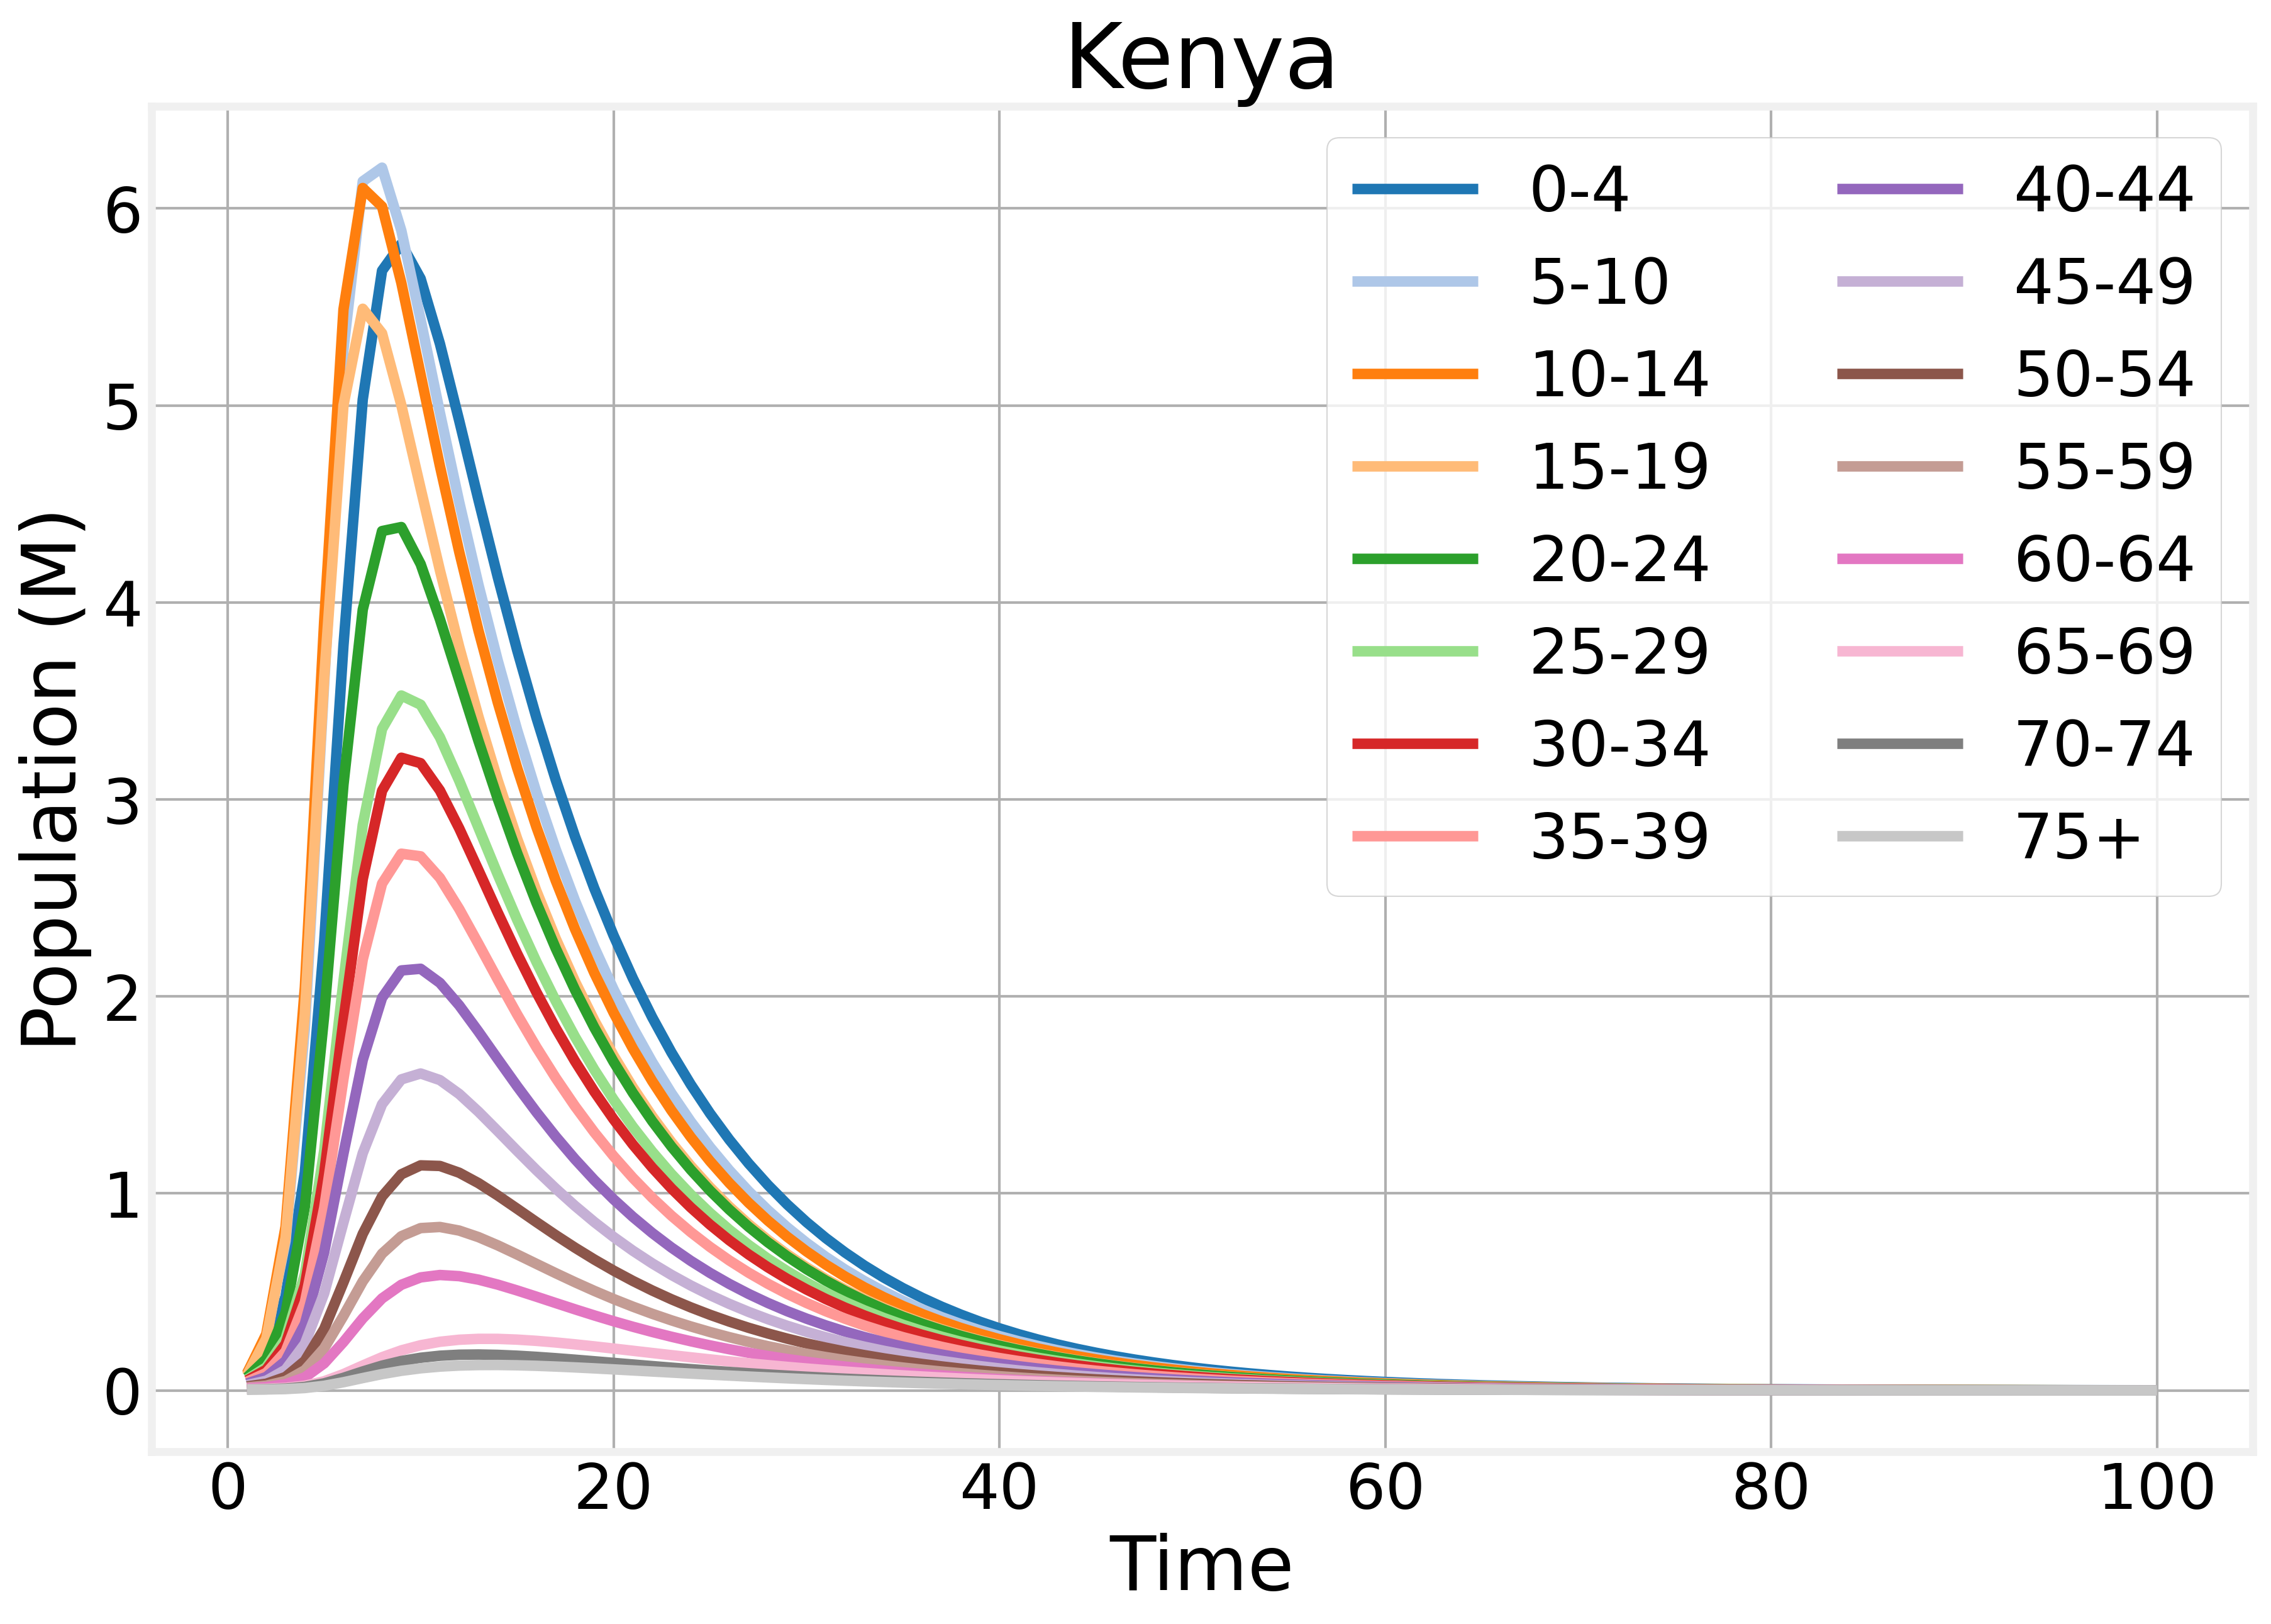

In [26]:
fig, ax = plt.subplots(1)
(SIR_ke.values_ages_[infected_compartments]/1e6).plot(ax=ax, color=plt.cm.tab20(np.arange(16)))
ax.legend(Ages, loc='upper right', ncols=2)
ax.set_xlabel('Time')
ax.set_ylabel('Population (M)')
ax.set_title('Kenya')

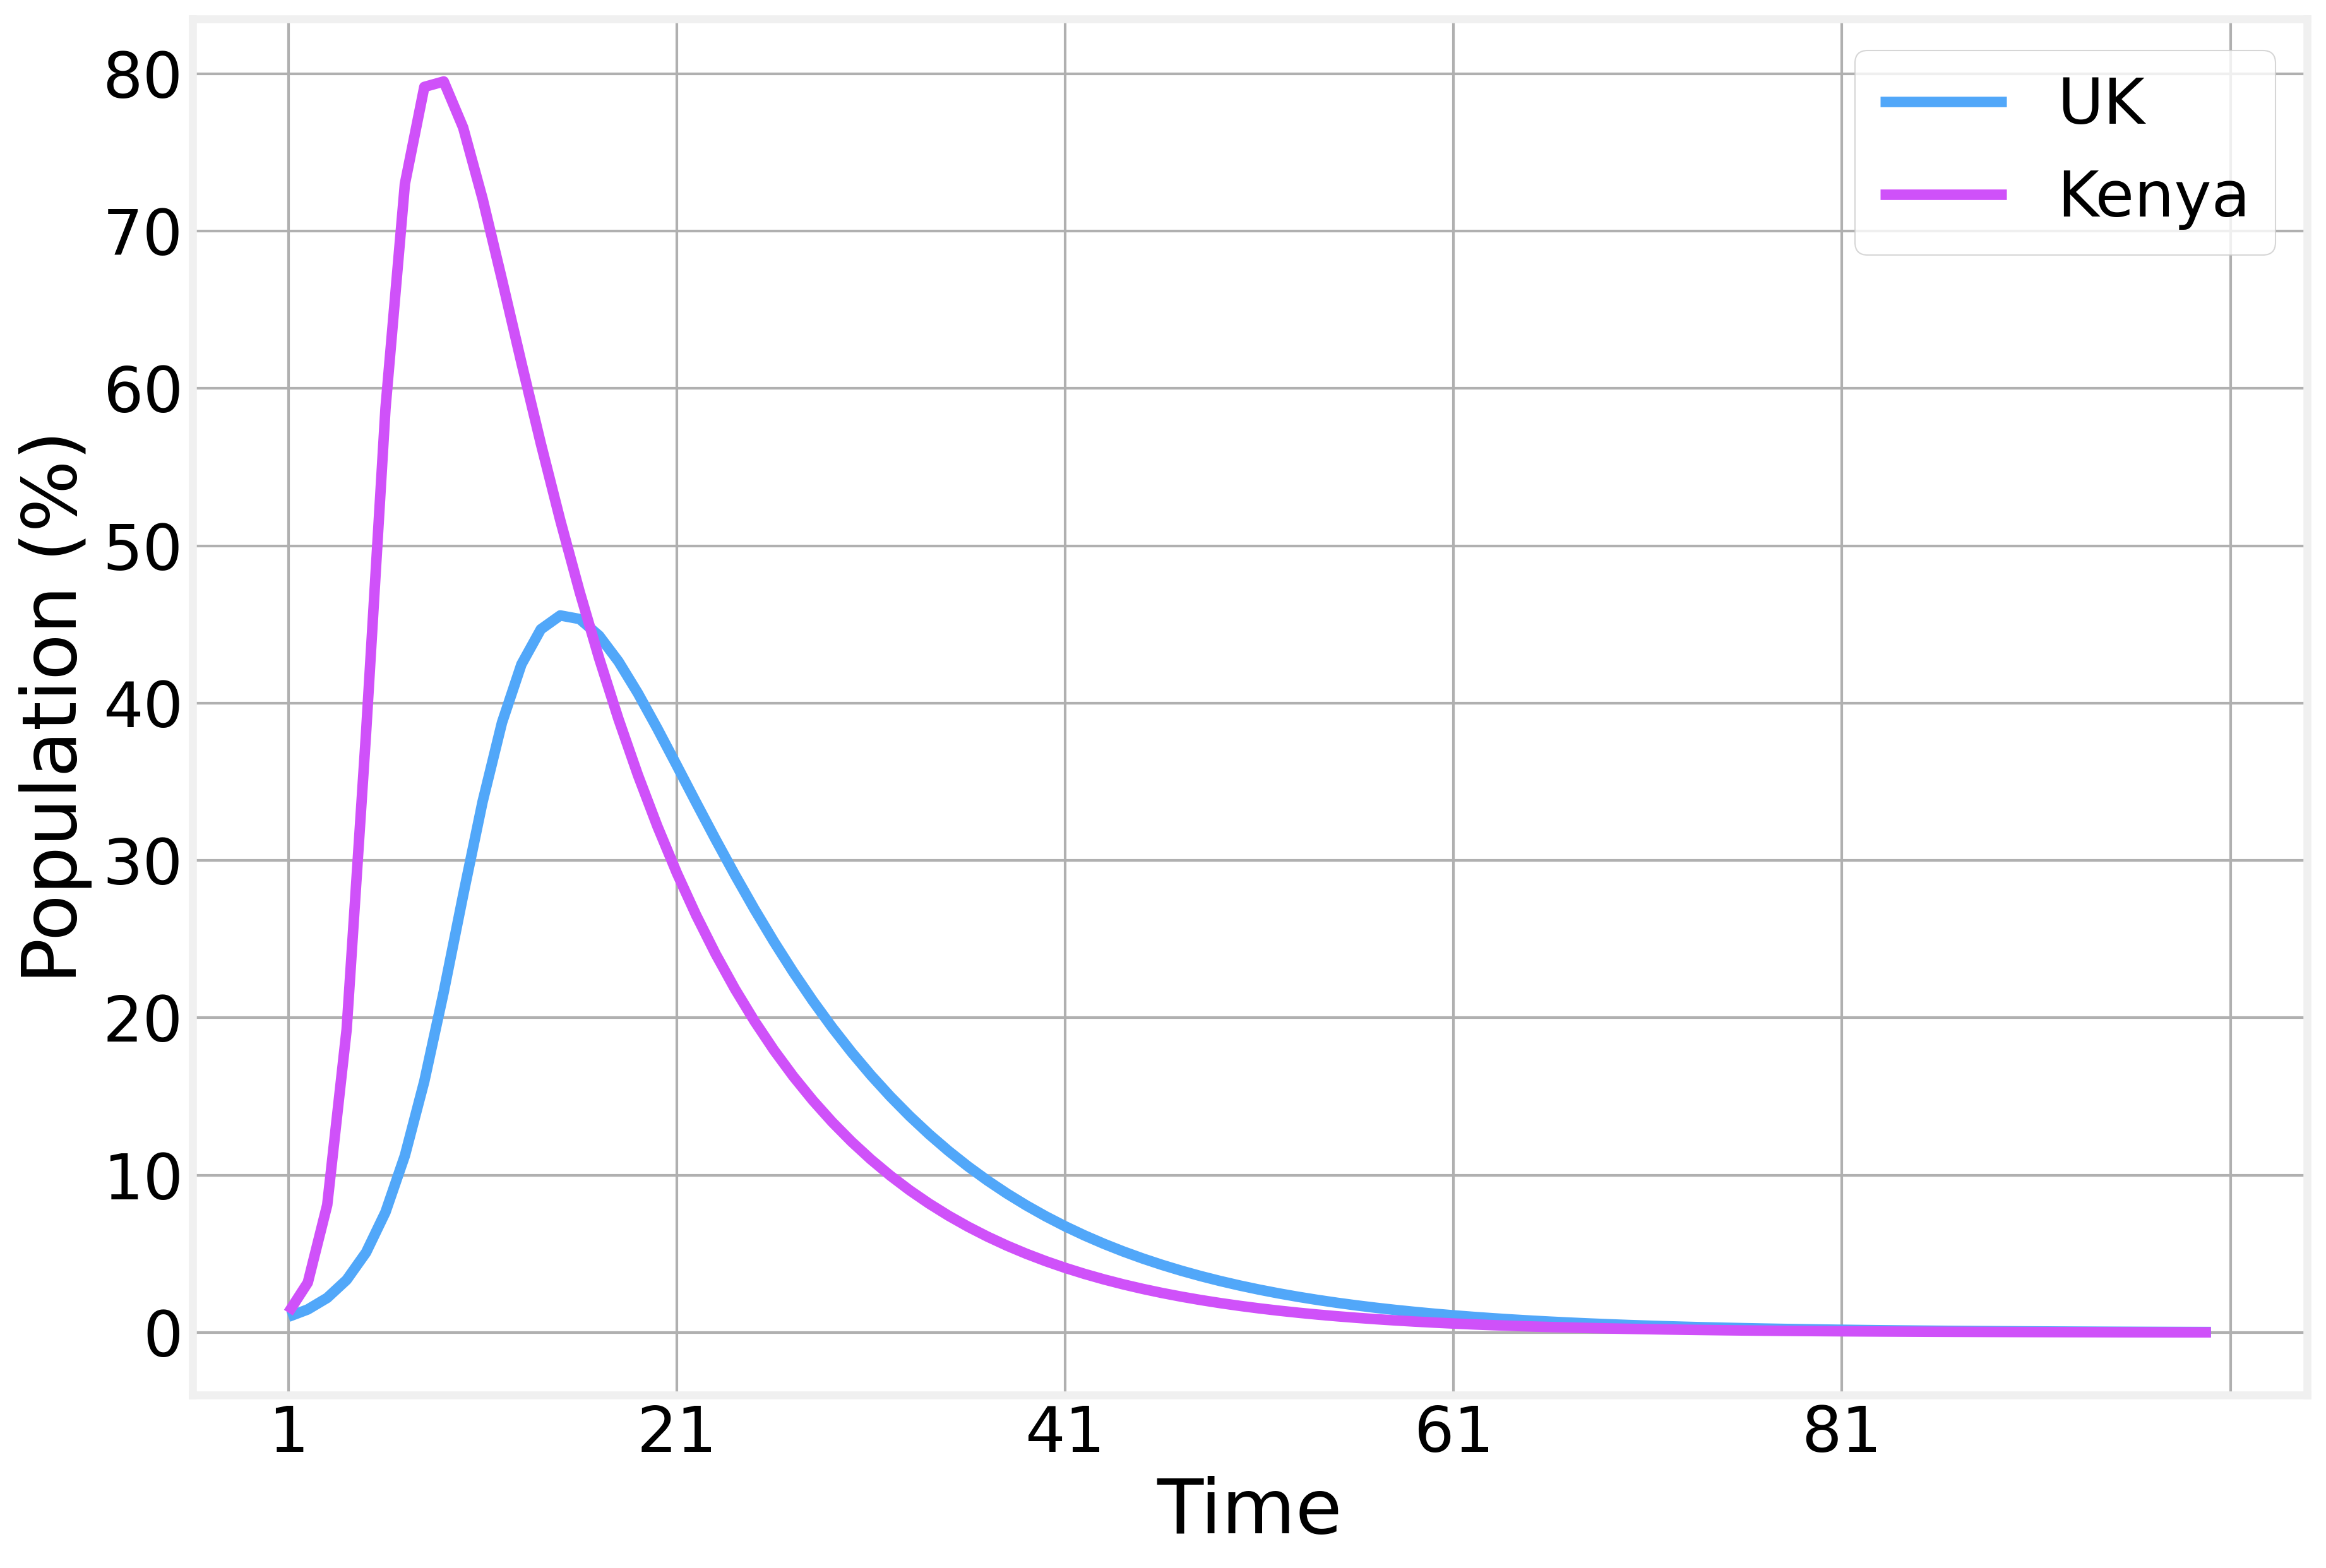

In [27]:
fig, ax = plt.subplots(1)

(SIR_uk['I']*100/N_uk).plot(ax=ax)
(SIR_ke['I']*100/N_ke).plot(ax=ax)
ax.legend(['UK', 'Kenya'])
ax.set_xlabel('Time')
ax.set_ylabel('Population (%)')

fig.tight_layout()

We can rescale the contact matrix to force the model to have the same value of $R_0$ as the UK model:

In [28]:
SIR_ke = EpiModel()
SIR_ke.add_interaction('S', 'I', 'I', beta)
SIR_ke.add_spontaneous('I', 'R', mu)

rescaling = R0_uk/R0_ke

SIR_ke.add_age_structure(contacts_ke * rescaling, Nk_ke)

In [29]:
SIR_ke.R0()

5.839713803900278

And integrate it, using similar parameters as for the UK

In [30]:
SIR_ke.integrate(100, S=N_ke*.99, I=N_ke*.01, R=0)

<Axes: title={'center': 'Kenya'}, xlabel='Time', ylabel='Population'>

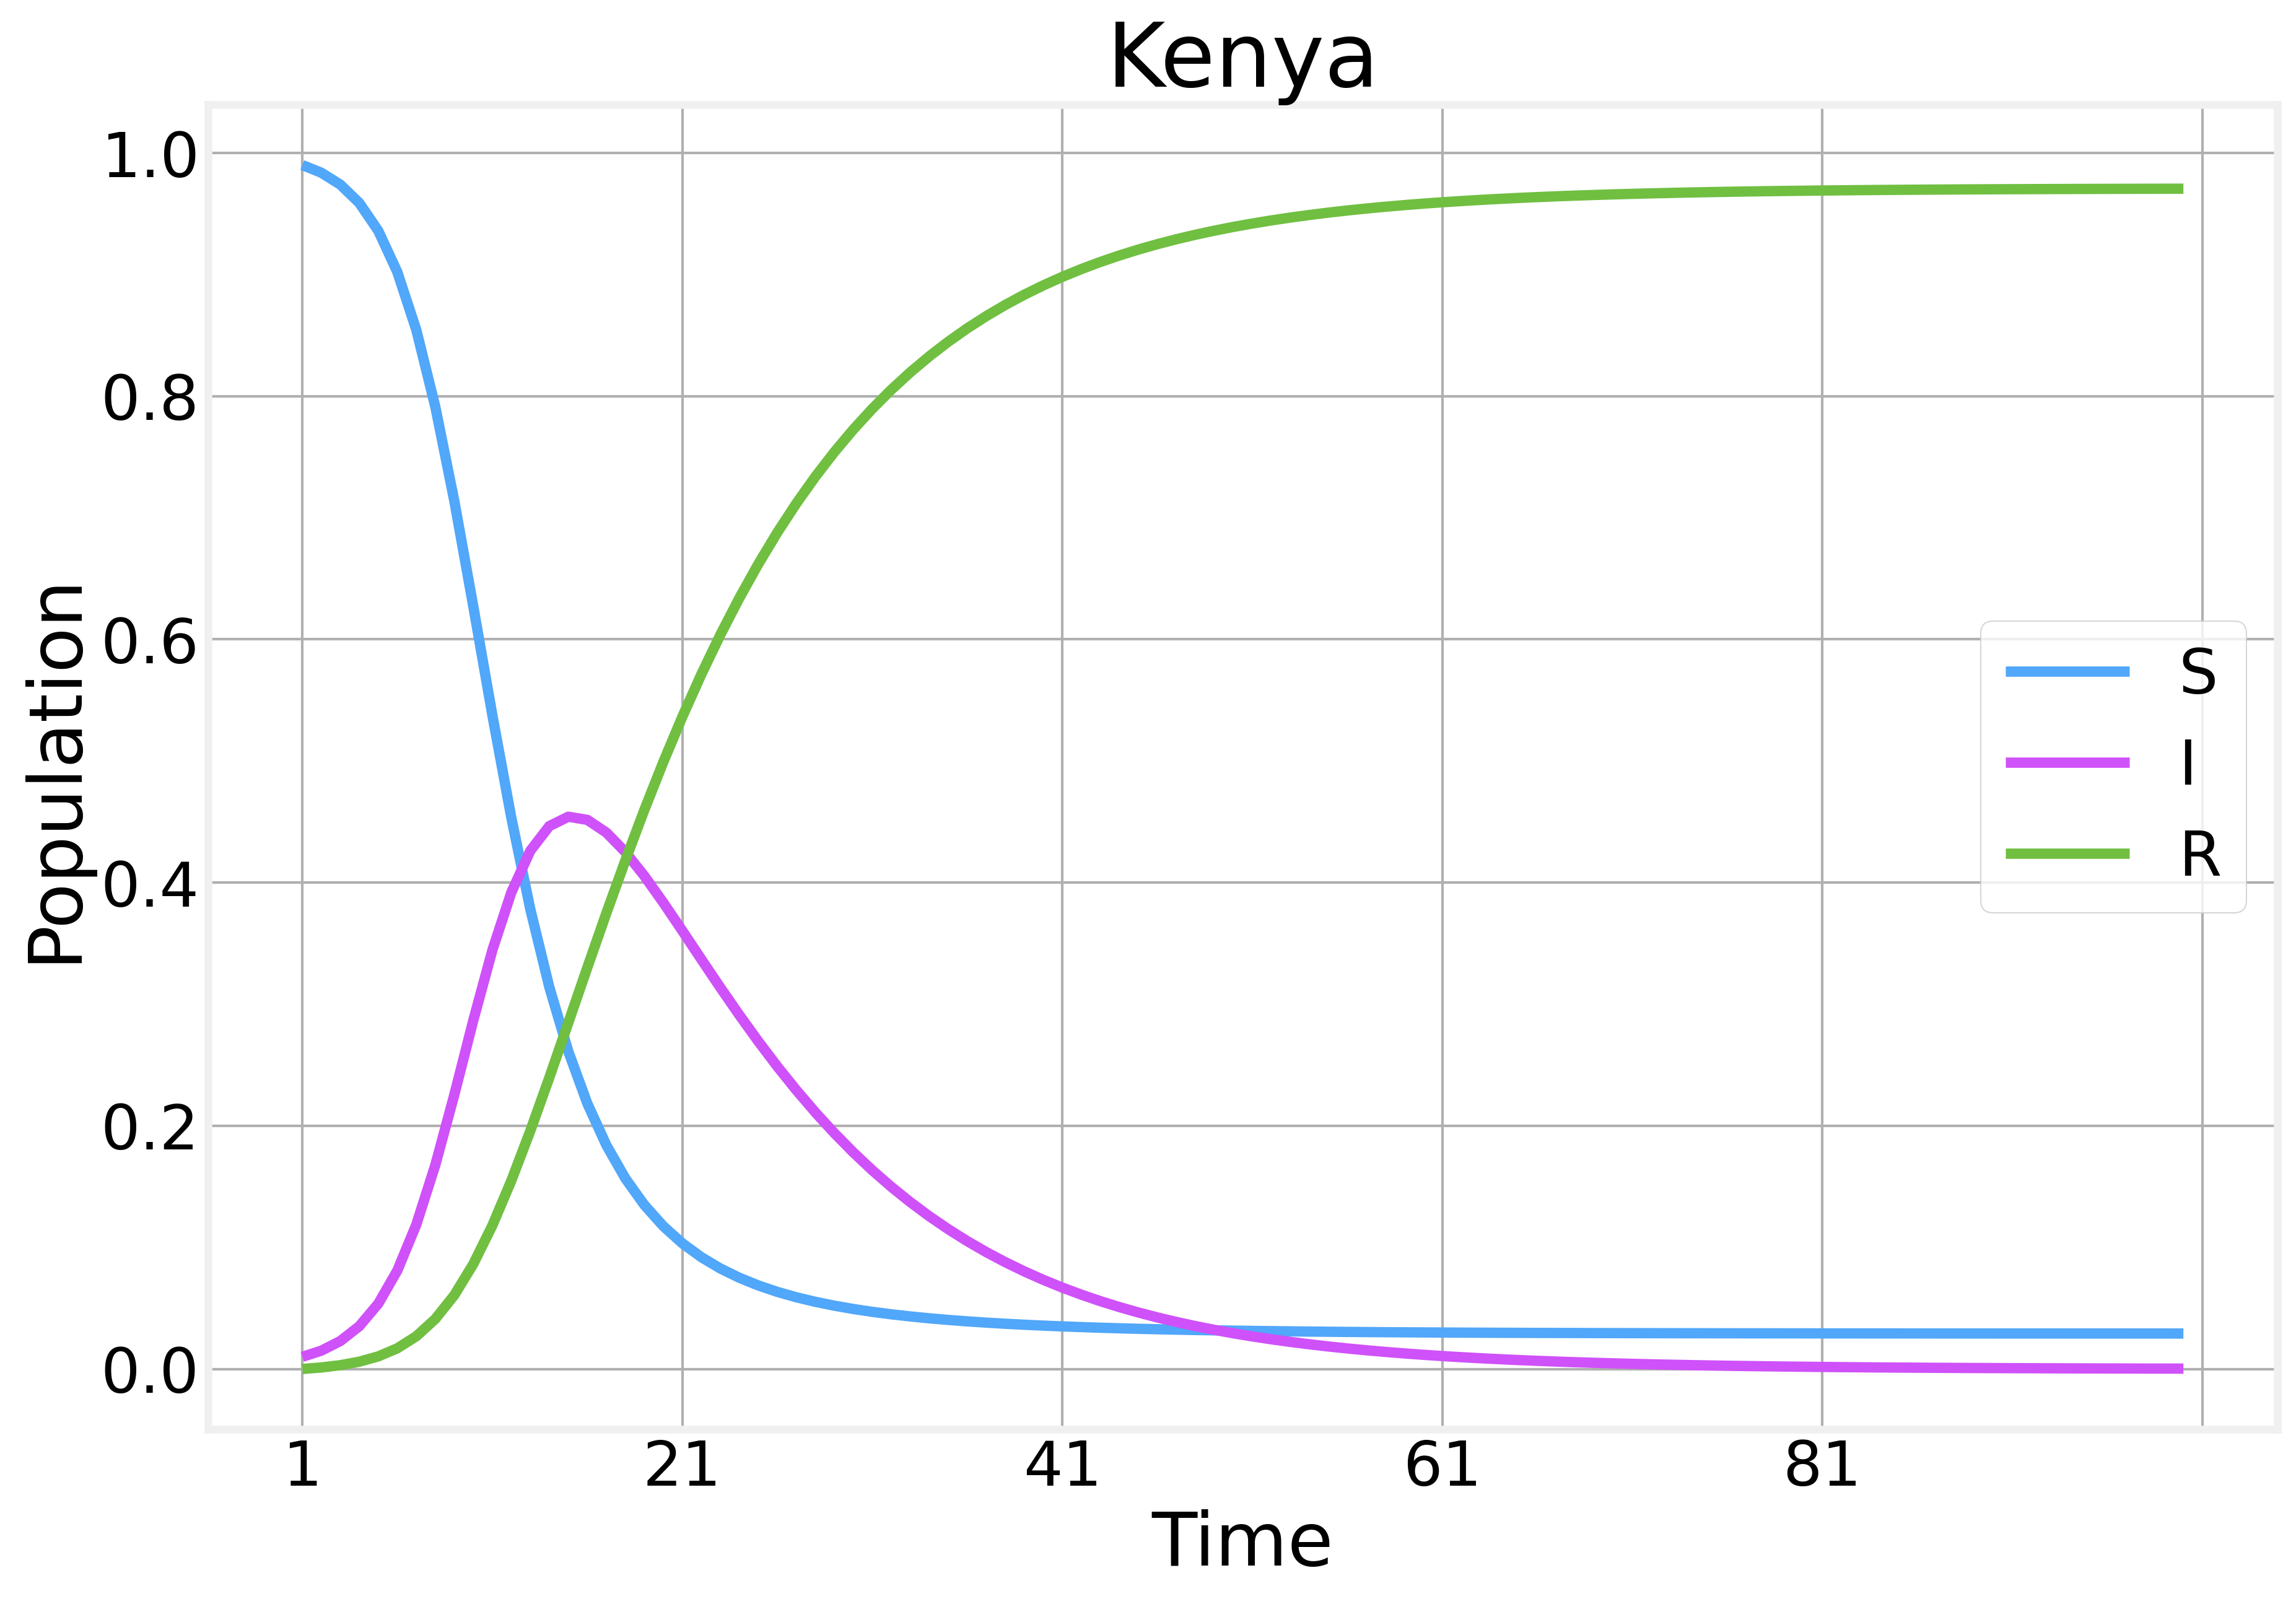

In [31]:
SIR_ke.plot(title='Kenya')

Naturally, a side by side comparison shows us that the two models are now identical. Regardless of the detailed differences in contact structure, $R_0$ is still the dominant factor in controling the overall progression of the epidemic

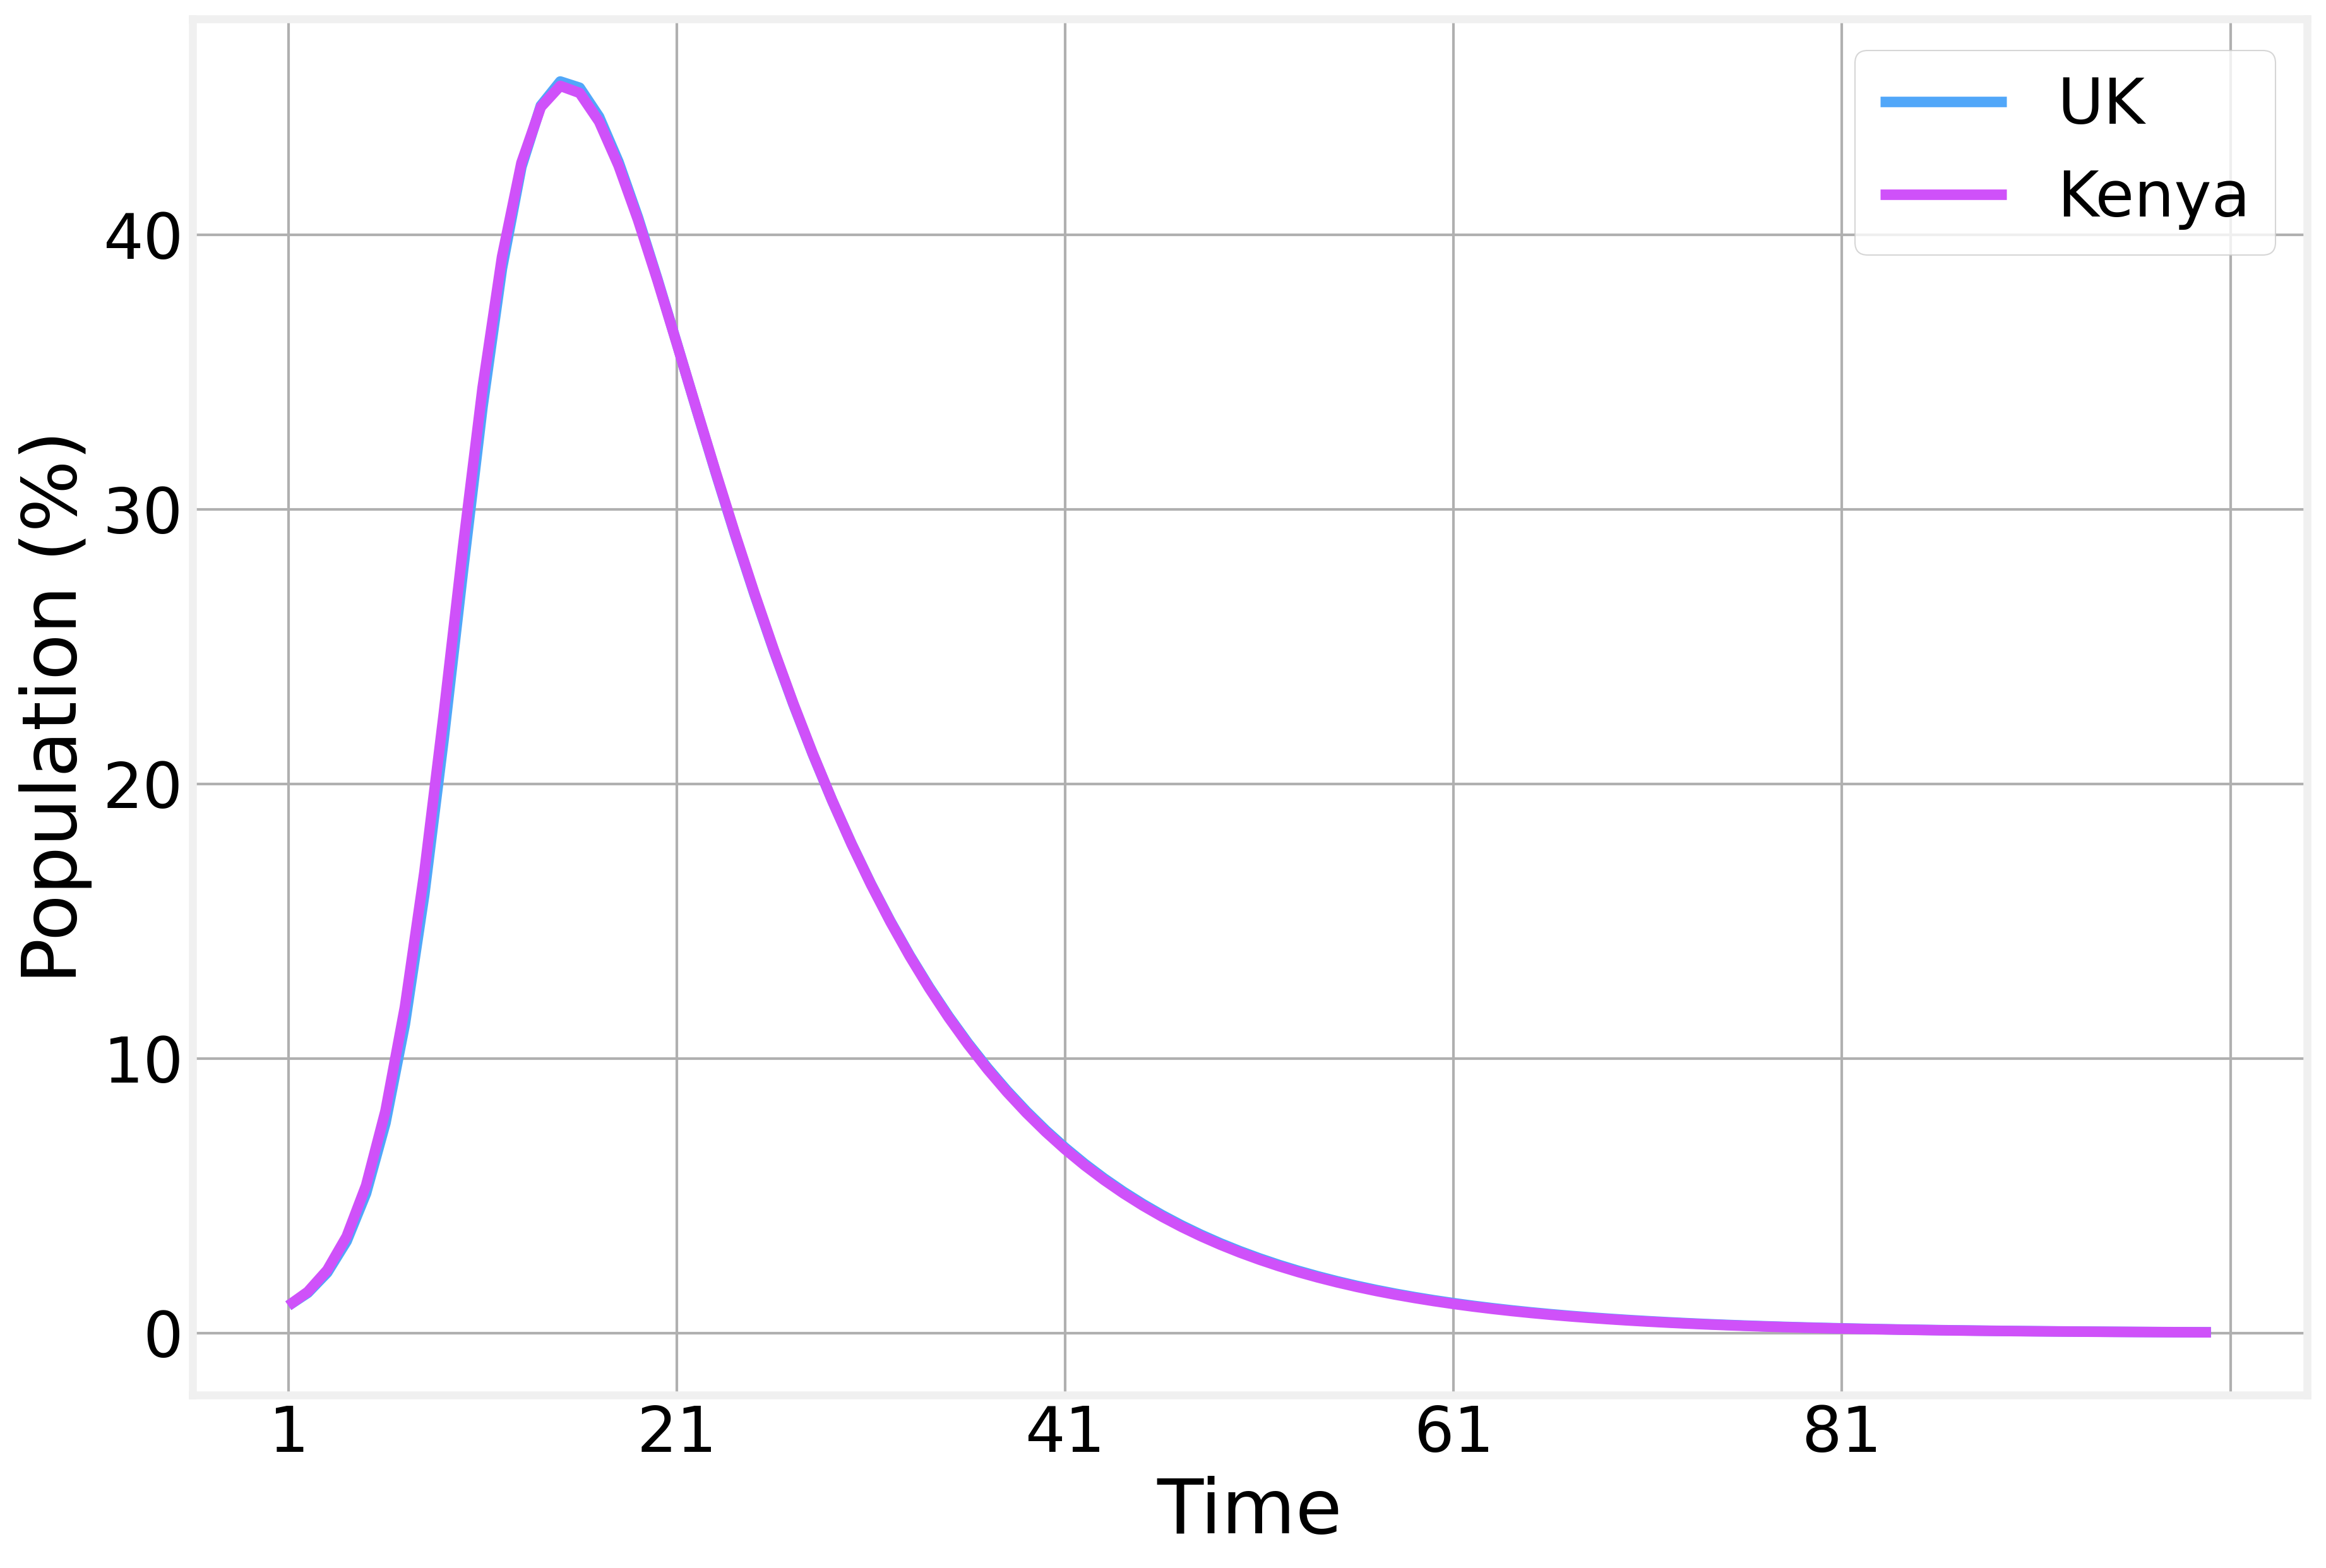

In [32]:
fig, ax = plt.subplots(1)

(SIR_uk['I']*100/N_uk).plot(ax=ax)
(SIR_ke['I']*100/N_ke).plot(ax=ax)
ax.legend(['UK', 'Kenya'])
ax.set_xlabel('Time')
ax.set_ylabel('Population (%)')

fig.tight_layout()

However, details matter. When we compare the distribution of cases across age groups, the differences are clear

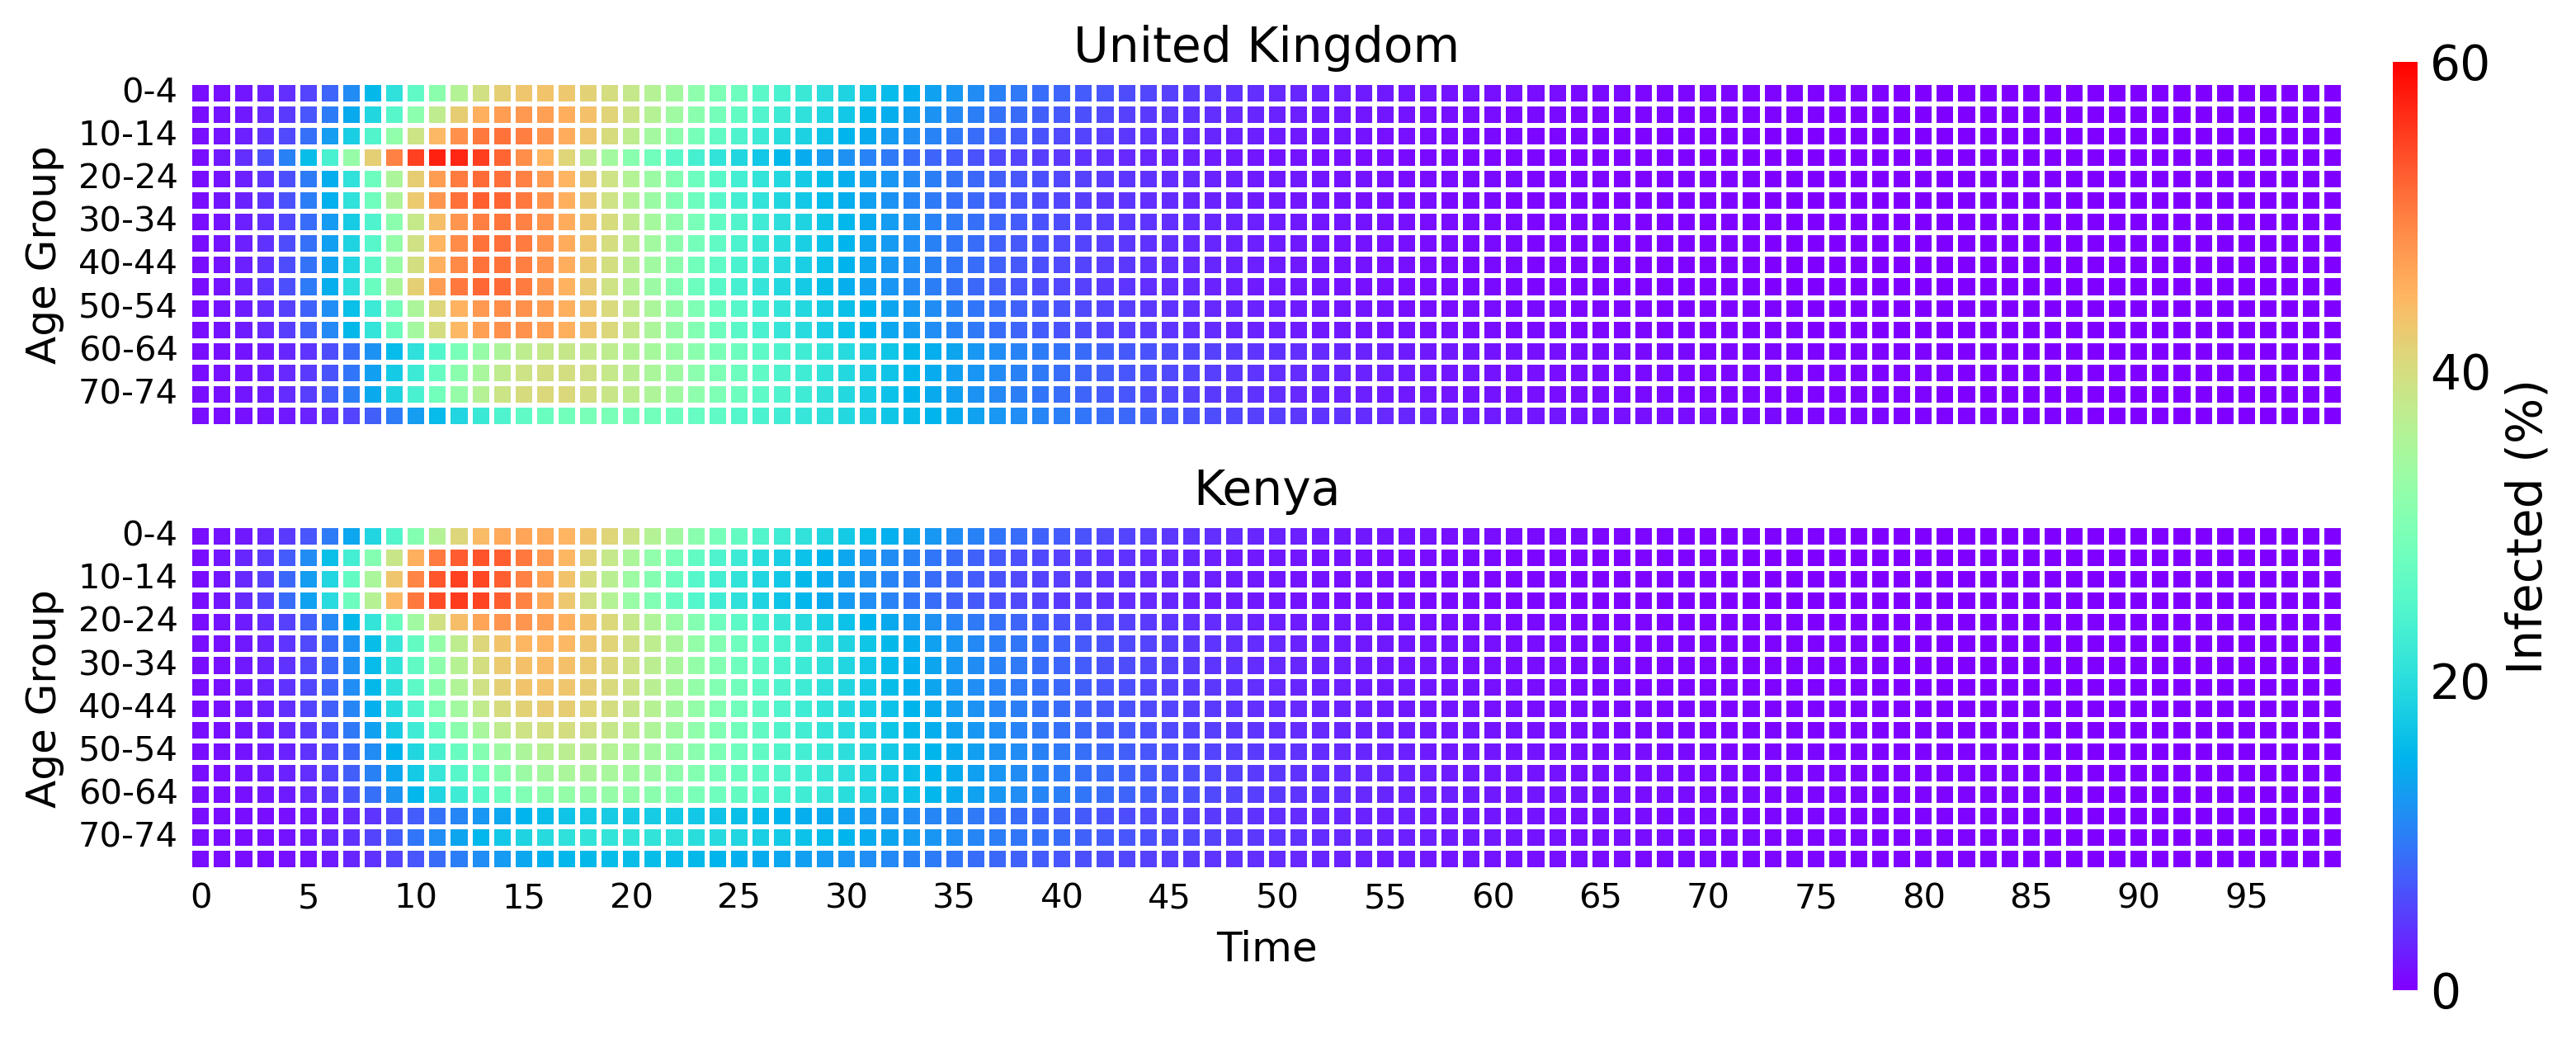

In [33]:
infected_compartments = [col for col in SIR_uk.values_ages_.columns if col.startswith('I')]


fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([.97, 0.03, 0.01, .75])
cbar_ax.set_ylabel(cbar_ax.get_xlabel(), fontsize=14)
cbar_ax.set_yticklabels(cbar_ax.get_xticklabels(), fontsize=14)


sns.heatmap((SIR_uk.values_ages_[infected_compartments].T).div(ages['UK'].values, axis=0)*100, cmap=plt.cm.rainbow, ax=axs[0],
            square=True, cbar=False, linewidth=1, linecolor='w', vmin=0, vmax=60,
            xticklabels=True, yticklabels=True)

sns.heatmap((SIR_ke.values_ages_[infected_compartments].T).div(ages['Kenya'].values, axis=0)*100, cmap=plt.cm.rainbow, ax=axs[1], 
            square=True, cbar_ax=cbar_ax, linewidth=1, linecolor='w', vmin=0, vmax=60,
            cbar_kws={'orientation':'vertical', 
                      'label':'Infected (%)',
                      },
            xticklabels=True, yticklabels=True)

axs[0].set_title('United Kingdom', fontsize=14)
axs[1].set_title('Kenya', fontsize=14)

age_groups = [col if i%2 == 0 else "" for i, col in enumerate(contacts_uk.columns)]

axs[0].set_yticklabels(age_groups, fontsize=10)
axs[1].set_yticklabels(age_groups, fontsize=10)

axs[0].set_ylabel('Age Group', fontsize=12)
axs[1].set_ylabel('Age Group', fontsize=12)


axs[1].set_xticklabels([val if val%5==0 else "" for val in np.arange(100)], 
                       fontsize=10, rotation=0)
axs[1].set_xlabel('Time', fontsize=12)

fig.subplots_adjust(hspace=-.3)

In [34]:
ages_compartment = ages.reset_index()
ages_compartment.rename(columns={'index':'age group'}, inplace=True)
age_dict = dict(ages_compartment[['age group', 'compartment']].values)
ages_compartment.set_index('compartment', inplace=True)

In [35]:
@interact
def plot_comparison(age_group = age_dict, Save=False):
    compartment = 'I_%s' % age_group
    ax = (SIR_uk[compartment]/ages_compartment.loc[age_group,'UK']*100).plot()
    (SIR_ke[compartment]/ages_compartment.loc[age_group,'Kenya']*100).plot(ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population (%)')
    ax.legend(['UK', 'Kenya'])
    ax.set_title("Age Group: %s" % ages_compartment.loc[age_group, 'age group'])
    
    if Save:
        plt.gcf().savefig('UK-Kenya-%s.png' % ages_compartment.loc[age_group, 'age group'], facecolor='white')

interactive(children=(Dropdown(description='age_group', options={'0-4': 'a', '5-10': 'b', '10-14': 'c', '15-19…

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>